In [2]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
import math
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *
from collections import Counter
import pandas as pd
import csv
import os.path
import scipy
from scipy.optimize import minimize

In [3]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 2
L2 = 2

lambda_vector = (2.1, 2.4, 3)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  0.   0.   2.4  0.  -1.  -1. ]
 [ 4.2  0.   0.   0.   0.   2.4 -1.  -1. ]
 [ 0.   0.   0.   4.2  0.   0.   2.4  0. ]
 [ 0.   0.   4.2  0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   4.2  0.   0. ]
 [ 0.   2.4  0.   0.   4.2  0.   0.   0. ]
 [-1.  -1.   2.4  0.   0.   0.   0.   4.2]
 [-1.  -1.   0.   2.4  0.   0.   4.2  0. ]]
Dn:
[2, 2, 2, 2]


In [4]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

In [5]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params): # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    
# Obtains the probability for all the states
@qml.qnode(dev)
def get_probs(params):
    circuit(params)
    return qml.probs(wires = qubits)

def CVaRsamp(params, alpha=1, n=100):#n=antal samples
    
    probs = get_probs(params)  # hämta sannolikhetsfördelningen (matris, första värdet är p(00000000), andra är p(00000001) osv)
    
    index_samples= np.random.choice(np.arange(len(probs), dtype=int), size=n, replace=True,p=probs)  # tar n samples av probs, ger skum lista med index motsvarande konfiguration (index 0 är tillståndet 00000000, index 1 =00000001 osv)
    energy_of_samples=energies_of_set(protein.get_solution_set(), H_cost,8) [index_samples]  #ger en lista där index i index_samples är utbytta mot deras motsvarande energi. 
    sorted_energy_samples=sort_over_threshhold(energy_of_samples,-10)[0] #sorterar hela energilistan
    K=int(alpha*n) #antal samples att ta väntevärde över. 
    summa=sum(sorted_energy_samples[:K]) #summera de K minsta energierna.
    expvalue=np.float64(summa/K)
    
    return expvalue

In [6]:
def cost_execution(params):
    params = np.reshape(params, (2, 1))

    global iterations

    cost = CVaRsamp(params, alpha=a, n=num_of_samples)

    if iterations % 50 == 0:
        print("Cost at Step {}: {}".format(iterations, cost))
    
    params_list.append(params)
    cost_list.append(cost)

    iterations += 1
    return cost

In [7]:
alphas = [0.05, 0.10, 0.25, 1.00]
num_of_samples = 32 #number of samples from the quantum computer/probability distribution
initial_params = np.array([[1],[1]], requires_grad = True) #first vector is alphas second is betas, (2,1) for P=1, (2,2) for p=2, (2,3) for p=3...
number_of_tests = 1000 #number of times you want to run the tests for each alpha, for statistical analysis this should be high
tolerance = 0.001 #Tolerance for when minimizer is done optimizing


data_library = {}
for a in alphas:
    print('Alpha is now :'+ str(a))
    print("="*100)
    counter = 0
    prob_list_list = []
    cost_list_list = []
    iter_needed_list = []
    
    for j in range(number_of_tests):
        iterations = 0
        params_list = []
        prob_list = []
        cost_list = []
        
        out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 1000}, tol=tolerance)
        out_params = np.reshape(out["x"], (2, len(initial_params[0])))
        print(out["x"])
        print(out["success"])
        probs = get_probs(out_params)
        ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states
        
        for i in range(len(params_list)):
            p = get_probs(params_list[i])
            prob_list.append(float(np.sum(p[ground_states_i])))

        prob_list_list.append(prob_list)
        cost_list_list.append(cost_list)
        iter_needed_list.append(iterations)
        
        counter+=1
        print(str(iterations) + ' iterations needed. CVaR cost ended at: ' + str(cost_list[-1]))
        print('Try ' + str(j+1) + ': Success probability of training: ', np.sum(probs[ground_states_i]))
        print("="*50)
    
    data = {
      "CVaR cost": cost_list_list,
      "Ground state probability": prob_list_list,
      "Iterations needed": iter_needed_list
    }
    
    var_name = "data_for_alpha_%s" % a
    data_library[var_name] = data
    
        

Alpha is now :0.05
Cost at Step 0: -6.6


/var/folders/cw/p649yvnd6tl_8jn4s2cchc7m0000gn/T/ipykernel_22823/2408895870.py:23: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 1000}, tol=tolerance)


[1.    0.999]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 1: Success probability of training:  0.013271715877395382
Cost at Step 0: -4.2
[2. 2.]
True
13 iterations needed. CVaR cost ended at: -6.6
Try 2: Success probability of training:  0.03411371496900126
Cost at Step 0: -4.5
[1. 2.]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 3: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.5
[0.99901682 2.00018265]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 4: Success probability of training:  0.0386303784497167
Cost at Step 0: -6.6
[1.001 1.   ]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 5: Success probability of training:  0.0132005837714829
Cost at Step 0: -4.2
[2. 2.]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 6: Success probability of training:  0.03411371496900126
Cost at Step 0: -4.5
[1. 2.]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 7: Success probability of training:  0.03884514724411985


[1.0006585  1.99924742]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 42: Success probability of training:  0.03902685152938982
Cost at Step 0: -4.5
[1.    0.501]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 43: Success probability of training:  0.032137664892929886
Cost at Step 0: -4.5
[2.001 1.   ]
True
13 iterations needed. CVaR cost ended at: -4.5
Try 44: Success probability of training:  0.02098965455625234
Cost at Step 0: -4.5
[1. 2.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 45: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.2
[1. 2.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 46: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.5
[2. 1.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 47: Success probability of training:  0.02108825447828893
Cost at Step 0: -6.6
[1.00089443 0.99955279]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 48: Success probability of traini

[1. 2.]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 83: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.2
[0.57786328 0.73061021]
True
23 iterations needed. CVaR cost ended at: -4.5
Try 84: Success probability of training:  0.018317971817395765
Cost at Step 0: -4.2
[2. 1.]
True
13 iterations needed. CVaR cost ended at: -6.6
Try 85: Success probability of training:  0.02108825447828893
Cost at Step 0: -6.6
[1.00078596 1.00061828]
True
19 iterations needed. CVaR cost ended at: -4.2
Try 86: Success probability of training:  0.013284537270842778
Cost at Step 0: -4.5
[2. 1.]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 87: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.5
[1.99967919 1.00094714]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 88: Success probability of training:  0.021106299448982527
Cost at Step 0: -4.2
[2.00025242 1.00096762]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 89: Success

[1. 2.]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 124: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.2
[2.00042112 1.00090701]
True
22 iterations needed. CVaR cost ended at: -2.1
Try 125: Success probability of training:  0.021033702895890904
Cost at Step 0: -6.6
[0.99915514 1.00053499]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 126: Success probability of training:  0.013529696368132418
Cost at Step 0: -6.6
[1. 1.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 127: Success probability of training:  0.013354604922747513
Cost at Step 0: -6.6
[1. 1.]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 128: Success probability of training:  0.013354604922747513
Cost at Step 0: -4.5
[ 9.99503861e-01 -8.68243142e-04]
True
25 iterations needed. CVaR cost ended at: -6.6
Try 129: Success probability of training:  0.01560244694063151
Cost at Step 0: -6.6
[1. 1.]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 130: Succe

[1. 1.]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 164: Success probability of training:  0.013354604922747513
Cost at Step 0: -4.5
[2.0004549  1.00089054]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 165: Success probability of training:  0.021030606795828494
Cost at Step 0: -4.5
[1. 2.]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 166: Success probability of training:  0.03884514724411985
Cost at Step 0: -6.6
[1. 1.]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 167: Success probability of training:  0.013354604922747513
Cost at Step 0: -6.6
[0.99922488 0.99936818]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 168: Success probability of training:  0.013421979013698963
Cost at Step 0: -6.6
[1.    1.001]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 169: Success probability of training:  0.01343736228004725
Cost at Step 0: -6.6
[1.00086491 0.99949807]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 170: Success p

[2. 1.]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 205: Success probability of training:  0.02108825447828893
Cost at Step 0: -6.6
[0.999 1.   ]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 206: Success probability of training:  0.013509328573331375
Cost at Step 0: -4.2
[2. 1.]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 207: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.5
[0.99964888 1.99906367]
True
19 iterations needed. CVaR cost ended at: -4.2
Try 208: Success probability of training:  0.03882835377930675
Cost at Step 0: -6.6
[0.999 1.   ]
True
17 iterations needed. CVaR cost ended at: -4.5
Try 209: Success probability of training:  0.013509328573331375
Cost at Step 0: -6.6
[1.001 1.   ]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 210: Success probability of training:  0.0132005837714829
Cost at Step 0: -4.5
[2.    1.001]
True
23 iterations needed. CVaR cost ended at: -4.5
Try 211: Success probability of tra

[1. 1.]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 246: Success probability of training:  0.013354604922747513
Cost at Step 0: -4.5
[1.99988952 1.00099388]
True
21 iterations needed. CVaR cost ended at: -1.4
Try 247: Success probability of training:  0.021084891052685788
Cost at Step 0: -4.5
[2. 1.]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 248: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.5
[1.99930761 0.99927847]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 249: Success probability of training:  0.021166523799048032
Cost at Step 0: -6.6
[1.0007226  1.00069127]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 250: Success probability of training:  0.013300319447333512
Cost at Step 0: -4.5
[1.99955279 1.00089443]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 251: Success probability of training:  0.021119513711344563
Cost at Step 0: -4.2
[2.00009149 1.99900419]
True
20 iterations needed. CVaR cost ended 

24 iterations needed. CVaR cost ended at: -4.2
Try 286: Success probability of training:  0.015631424586651947
Cost at Step 0: -4.5
[1.  0.5]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 287: Success probability of training:  0.0322599177139716
Cost at Step 0: -4.5
[0.53846154 0.80769231]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 288: Success probability of training:  0.03446798497838314
Cost at Step 0: -6.6
[1. 1.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 289: Success probability of training:  0.013354604922747513
Cost at Step 0: -6.6
[1. 1.]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 290: Success probability of training:  0.013354604922747513
Cost at Step 0: -4.5
[1. 2.]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 291: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.2
[2. 1.]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 292: Success probability of training:  0.02108825447828893
Cost a

[1.00009881 0.99900489]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 327: Success probability of training:  0.01325690003704456
Cost at Step 0: -4.5
[2. 1.]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 328: Success probability of training:  0.02108825447828893
Cost at Step 0: -6.6
[0.9991631  0.99945265]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 329: Success probability of training:  0.013438564131261986
Cost at Step 0: -3.4
[1. 2.]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 330: Success probability of training:  0.03884514724411985
Cost at Step 0: -6.6
[1.001 1.   ]
True
16 iterations needed. CVaR cost ended at: -4.2
Try 331: Success probability of training:  0.0132005837714829
Cost at Step 0: -4.5
[2. 1.]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 332: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.2
[2.70710678 0.29289322]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 333: Success proba

[1.    1.001]
True
16 iterations needed. CVaR cost ended at: -4.5
Try 368: Success probability of training:  0.01343736228004725
Cost at Step 0: -4.5
[1.  0.5]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 369: Success probability of training:  0.0322599177139716
Cost at Step 0: -6.6
[1. 1.]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 370: Success probability of training:  0.013354604922747513
Cost at Step 0: -6.6
[0.99955279 1.00089443]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 371: Success probability of training:  0.013497851812034722
Cost at Step 0: -4.5
[1. 2.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 372: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.5
[2. 1.]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 373: Success probability of training:  0.02108825447828893
Cost at Step 0: -6.6
[1. 1.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 374: Success probability of training:  0.013354

[2. 1.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 409: Success probability of training:  0.02108825447828893
Cost at Step 0: -6.6
[0.99934646 1.00075689]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 410: Success probability of training:  0.013518433367985652
Cost at Step 0: -4.2
[2.00060543 0.9992041 ]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 411: Success probability of training:  0.02103989690864396
Cost at Step 0: -6.6
[1.00010567 1.0009944 ]
True
20 iterations needed. CVaR cost ended at: -4.2
Try 412: Success probability of training:  0.013420561000081236
Cost at Step 0: -4.5
[2.00042766 0.99909606]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 413: Success probability of training:  0.021058926882427137
Cost at Step 0: -4.5
[ 9.99131757e-01 -4.96138938e-04]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 414: Success probability of training:  0.01561215954011529
Cost at Step 0: -6.6
[1.001 1.   ]
True
18 iterations needed. CV

[1. 1.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 450: Success probability of training:  0.013354604922747513
Cost at Step 0: -6.6
[1. 1.]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 451: Success probability of training:  0.013354604922747513
Cost at Step 0: -4.5
[1.99970407 0.99904479]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 452: Success probability of training:  0.02113082761913749
Cost at Step 0: -4.5
[1. 2.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 453: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.2
[2. 1.]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 454: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.5
[2. 1.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 455: Success probability of training:  0.02108825447828893
Cost at Step 0: -6.6
[0.999224   1.00063073]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 456: Success probability of training: 

20 iterations needed. CVaR cost ended at: -6.6
Try 491: Success probability of training:  0.013325893133587789
Cost at Step 0: -6.6
[1. 1.]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 492: Success probability of training:  0.013354604922747513
Cost at Step 0: -4.5
[2. 1.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 493: Success probability of training:  0.02108825447828893
Cost at Step 0: -6.6
[1. 1.]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 494: Success probability of training:  0.013354604922747513
Cost at Step 0: -4.5
[1.00089443 1.99955279]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 495: Success probability of training:  0.03905770301846281
Cost at Step 0: -4.5
[1.  0.5]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 496: Success probability of training:  0.0322599177139716
Cost at Step 0: -4.5
[0.99968159 2.00094795]
True
18 iterations needed. CVaR cost ended at: -3.4
Try 497: Success probability of training:  0.03872150

[1. 1.]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 532: Success probability of training:  0.013354604922747513
Cost at Step 0: -6.6
[1. 1.]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 533: Success probability of training:  0.013354604922747513
Cost at Step 0: -4.5
[1. 2.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 534: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.5
[1.999 1.   ]
True
16 iterations needed. CVaR cost ended at: -4.5
Try 535: Success probability of training:  0.021186632777749452
Cost at Step 0: -6.6
[1. 1.]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 536: Success probability of training:  0.013354604922747513
Cost at Step 0: -4.5
[1. 2.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 537: Success probability of training:  0.03884514724411985
Cost at Step 0: -6.6
[0.99900451 0.99990516]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 538: Success probability of training:  0.01350

[1.00063281 2.00077431]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 573: Success probability of training:  0.03892968397891476
Cost at Step 0: -6.6
[1.    1.001]
True
18 iterations needed. CVaR cost ended at: -4.5
Try 574: Success probability of training:  0.01343736228004725
Cost at Step 0: -4.2
[2.001 1.   ]
True
17 iterations needed. CVaR cost ended at: -4.5
Try 575: Success probability of training:  0.02098965455625234
Cost at Step 0: -4.5
[1.001   1.03125]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 576: Success probability of training:  0.015695910412002877
Cost at Step 0: -4.5
[1. 2.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 577: Success probability of training:  0.03884514724411985
Cost at Step 0: -6.6
[1.00013051 0.99900855]
True
22 iterations needed. CVaR cost ended at: -6.6
Try 578: Success probability of training:  0.013252320949760187
Cost at Step 0: -6.6
[1. 1.]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 579: Success pro

[2.001 1.   ]
True
17 iterations needed. CVaR cost ended at: -4.5
Try 614: Success probability of training:  0.02098965455625234
Cost at Step 0: -6.6
[1.    1.001]
True
23 iterations needed. CVaR cost ended at: -6.6
Try 615: Success probability of training:  0.01343736228004725
Cost at Step 0: -6.6
[0.999 1.   ]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 616: Success probability of training:  0.013509328573331375
Cost at Step 0: -4.5
[1.00056157e+00 8.27427876e-04]
True
24 iterations needed. CVaR cost ended at: -4.5
Try 617: Success probability of training:  0.015647330662790938
Cost at Step 0: -3.5
[2. 1.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 618: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.5
[1. 2.]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 619: Success probability of training:  0.03884514724411985
Cost at Step 0: -6.6
[1.00033747 0.99905866]
True
18 iterations needed. CVaR cost ended at: -4.5
Try 620: Success

[0.99941452 0.99918931]
True
21 iterations needed. CVaR cost ended at: -6.6
Try 655: Success probability of training:  0.013377787087968029
Cost at Step 0: -4.2
[2. 1.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 656: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.2
[-0.00346397 -0.36066471]
True
23 iterations needed. CVaR cost ended at: -6.6
Try 657: Success probability of training:  0.014927961036002278
Cost at Step 0: -6.6
[1. 1.]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 658: Success probability of training:  0.013354604922747513
Cost at Step 0: -4.5
[0.99953352 1.99911547]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 659: Success probability of training:  0.03880138681808055
Cost at Step 0: -6.6
[1.00021168 0.99902266]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 660: Success probability of training:  0.01324099218737267
Cost at Step 0: -6.6
[1.00054684 0.99916276]
True
18 iterations needed. CVaR cost ended 

[2.00092431 0.99961837]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 696: Success probability of training:  0.021002585271658023
Cost at Step 0: -4.5
[2.00089443 1.00044721]
True
24 iterations needed. CVaR cost ended at: -3.1
Try 697: Success probability of training:  0.020993632019804323
Cost at Step 0: -6.6
[0.99939125 0.99920664]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 698: Success probability of training:  0.013382822643917151
Cost at Step 0: -4.5
[1. 2.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 699: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.2
[2. 2.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 700: Success probability of training:  0.03411371496900126
Cost at Step 0: -4.2
[2. 2.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 701: Success probability of training:  0.03411371496900126
Cost at Step 0: -4.5
[1.99983456 0.99901378]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 702: 

[3. 1.]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 737: Success probability of training:  0.027393261150905117
Cost at Step 0: -6.6
[0.99910557 0.99955279]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 738: Success probability of training:  0.01345579542093772
Cost at Step 0: -6.6
[1.    0.999]
True
17 iterations needed. CVaR cost ended at: -4.5
Try 739: Success probability of training:  0.013271715877395382
Cost at Step 0: -4.5
[1. 2.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 740: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.2
[2.70710678 0.29289322]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 741: Success probability of training:  0.030779616718613744
Cost at Step 0: -4.5
[2.00064006 0.99923167]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 742: Success probability of training:  0.02103609642315464
Cost at Step 0: -4.5
[1. 2.]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 743: Success pr

[1.0006585  2.00075258]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 778: Success probability of training:  0.03893635021183929
Cost at Step 0: -4.5
[2.001 1.   ]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 779: Success probability of training:  0.02098965455625234
Cost at Step 0: -6.6
[1.    1.001]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 780: Success probability of training:  0.01343736228004725
Cost at Step 0: -4.5
[1. 2.]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 781: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.2
[2. 1.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 782: Success probability of training:  0.02108825447828893
Cost at Step 0: -6.6
[0.99948963 0.99914005]
True
18 iterations needed. CVaR cost ended at: -4.2
Try 783: Success probability of training:  0.013362087786482034
Cost at Step 0: -6.6
[1. 1.]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 784: Success probability of

[1. 2.]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 819: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.5
[1. 2.]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 820: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.5
[2. 1.]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 821: Success probability of training:  0.02108825447828893
Cost at Step 0: -6.6
[0.99983098 0.99901439]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 822: Success probability of training:  0.013298964858673108
Cost at Step 0: -4.2
[2.70710678 0.29289322]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 823: Success probability of training:  0.030779616718613744
Cost at Step 0: -6.6
[1.001 1.   ]
True
18 iterations needed. CVaR cost ended at: -4.5
Try 824: Success probability of training:  0.0132005837714829
Cost at Step 0: -4.5
[2. 1.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 825: Success probability of train

[0.99980634 0.99901893]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 860: Success probability of training:  0.01330314201881799
Cost at Step 0: -4.5
[2. 1.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 861: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.2
[1.9993415  0.99924742]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 862: Success probability of training:  0.02116362861974457
Cost at Step 0: -4.2
[2. 1.]
True
18 iterations needed. CVaR cost ended at: -6.6
Try 863: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.5
[2.001 1.   ]
True
13 iterations needed. CVaR cost ended at: -2.1
Try 864: Success probability of training:  0.02098965455625234
Cost at Step 0: -6.6
[0.99955279 1.00089443]
True
20 iterations needed. CVaR cost ended at: -4.2
Try 865: Success probability of training:  0.013497851812034722
Cost at Step 0: -4.5
[2. 1.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 866: Success prob

[2. 2.]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 901: Success probability of training:  0.03411371496900126
Cost at Step 0: -6.6
[1. 1.]
True
16 iterations needed. CVaR cost ended at: -6.6
Try 902: Success probability of training:  0.013354604922747513
Cost at Step 0: -4.5
[1. 2.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 903: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.5
[9.99406148e-01 8.04574080e-04]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 904: Success probability of training:  0.015646221656398212
Cost at Step 0: -4.2
[2. 2.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 905: Success probability of training:  0.03411371496900126
Cost at Step 0: -6.6
[1.    1.001]
True
19 iterations needed. CVaR cost ended at: -4.2
Try 906: Success probability of training:  0.01343736228004725
Cost at Step 0: -6.6
[0.99946191 1.00084288]
True
17 iterations needed. CVaR cost ended at: -4.5
Try 907: Success probability

[1. 2.]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 942: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.2
[2. 2.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 943: Success probability of training:  0.03411371496900126
Cost at Step 0: -3.1
[2. 1.]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 944: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.5
[0.71259553 0.04317211]
True
23 iterations needed. CVaR cost ended at: -4.5
Try 945: Success probability of training:  0.010482642753580736
Cost at Step 0: -4.5
[2. 1.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 946: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.5
[2. 1.]
True
20 iterations needed. CVaR cost ended at: -6.6
Try 947: Success probability of training:  0.02108825447828893
Cost at Step 0: -6.6
[0.99904285 1.0002896 ]
True
22 iterations needed. CVaR cost ended at: -4.2
Try 948: Success probability of training:  

[1. 2.]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 983: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.5
[1. 2.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 984: Success probability of training:  0.03884514724411985
Cost at Step 0: -6.6
[0.999 1.   ]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 985: Success probability of training:  0.013509328573331375
Cost at Step 0: -4.5
[2. 1.]
True
15 iterations needed. CVaR cost ended at: -6.6
Try 986: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.5
[1.  0.5]
True
19 iterations needed. CVaR cost ended at: -6.6
Try 987: Success probability of training:  0.0322599177139716
Cost at Step 0: -4.2
[2. 1.]
True
14 iterations needed. CVaR cost ended at: -6.6
Try 988: Success probability of training:  0.02108825447828893
Cost at Step 0: -4.2
[2.00027238 0.99903781]
True
17 iterations needed. CVaR cost ended at: -6.6
Try 989: Success probability of training:  0.0210750

[2.00059719 1.0008021 ]
True
19 iterations needed. CVaR cost ended at: -4.166666666666667
Try 21: Success probability of training:  0.021017841958304827
Cost at Step 0: -5.2
[0.52251016 0.85116993]
True
24 iterations needed. CVaR cost ended at: -5.2
Try 22: Success probability of training:  0.0493230508793633
Cost at Step 0: -4.3
[1.75004354 0.98613641]
True
20 iterations needed. CVaR cost ended at: -4.766666666666667
Try 23: Success probability of training:  0.02062480332055787
Cost at Step 0: -4.066666666666666
[1.99955226 1.11691413]
True
24 iterations needed. CVaR cost ended at: -4.866666666666666
Try 24: Success probability of training:  0.01856500017160146
Cost at Step 0: -4.3
[0.23375446 2.64403332]
True
16 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 25: Success probability of training:  0.11166110804052956
Cost at Step 0: -3.966666666666667
[-1.17430149 -2.07695197]
True
23 iterations needed. CVaR cost ended at: -6.599999999999999
Try 26: Success probability 

[2.00095392 0.99969995]
True
20 iterations needed. CVaR cost ended at: -4.166666666666667
Try 58: Success probability of training:  0.020998499935122476
Cost at Step 0: -5.0
[0.99938699 2.00079007]
True
21 iterations needed. CVaR cost ended at: -5.566666666666666
Try 59: Success probability of training:  0.03867007657475806
Cost at Step 0: -5.1000000000000005
[2.1068201  0.93578264]
True
21 iterations needed. CVaR cost ended at: -3.8000000000000003
Try 60: Success probability of training:  0.01198795131275126
Cost at Step 0: -5.1000000000000005
[1.73724994e-04 9.58196085e-01]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 61: Success probability of training:  0.015647857991460318
Cost at Step 0: -4.5
[1.00090841 0.49958192]
True
22 iterations needed. CVaR cost ended at: -5.0
Try 62: Success probability of training:  0.03250202324716803
Cost at Step 0: -5.1000000000000005
[0.50064512 0.97460907]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 63: Success p

24 iterations needed. CVaR cost ended at: -4.5
Try 94: Success probability of training:  0.0284028160965692
Cost at Step 0: -5.0
[2.0000863  0.99900373]
True
18 iterations needed. CVaR cost ended at: -5.2
Try 95: Success probability of training:  0.021093816684635877
Cost at Step 0: -4.5
[1.38437848 2.06026113]
True
24 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 96: Success probability of training:  0.05688366448995272
Cost at Step 0: -4.2
[2.00074231 1.99932994]
True
20 iterations needed. CVaR cost ended at: -5.566666666666666
Try 97: Success probability of training:  0.03417120138397747
Cost at Step 0: -5.2
[0.94187108 2.02177674]
True
22 iterations needed. CVaR cost ended at: -2.733333333333333
Try 98: Success probability of training:  0.026368691937593784
Cost at Step 0: -5.1000000000000005
[0.95863233 1.04792218]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 99: Success probability of training:  0.024337923625505894
Cost at Step 0: -4.3
[ 0.14636694 -0

25 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 130: Success probability of training:  0.044808142896060735
Cost at Step 0: -4.3999999999999995
[1.02760994 1.07880611]
True
24 iterations needed. CVaR cost ended at: -4.866666666666666
Try 131: Success probability of training:  0.014812412463207456
Cost at Step 0: -5.1000000000000005
[0.68323342 2.94952572]
True
21 iterations needed. CVaR cost ended at: -6.599999999999999
Try 132: Success probability of training:  0.07332127114943199
Cost at Step 0: -5.0
[1.99913075 2.00049437]
True
21 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 133: Success probability of training:  0.03404827157366129
Cost at Step 0: -5.0
[2.74744125 0.33663565]
True
21 iterations needed. CVaR cost ended at: -5.8
Try 134: Success probability of training:  0.034688121597801214
Cost at Step 0: -4.3
[0.21064778 2.61394061]
True
18 iterations needed. CVaR cost ended at: -6.599999999999999
Try 135: Success probability of training:  0.092

[2.00106468 0.99889954]
True
21 iterations needed. CVaR cost ended at: -4.3999999999999995
Try 166: Success probability of training:  0.020998940554669027
Cost at Step 0: -4.3
[0.23016045 1.35318017]
True
26 iterations needed. CVaR cost ended at: -6.599999999999999
Try 167: Success probability of training:  0.0783534852820183
Cost at Step 0: -4.3
[1.44385296 1.77136751]
True
24 iterations needed. CVaR cost ended at: -6.599999999999999
Try 168: Success probability of training:  0.03356401995026564
Cost at Step 0: -4.3999999999999995
[1.33050107 0.73151888]
True
23 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 169: Success probability of training:  0.04821507928099826
Cost at Step 0: -4.3
[1.32289449 0.62044779]
True
21 iterations needed. CVaR cost ended at: -4.833333333333333
Try 170: Success probability of training:  0.06573871285207293
Cost at Step 0: -4.2
[0.57699311 3.05818868]
True
23 iterations needed. CVaR cost ended at: -5.0
Try 171: Success probability of train

22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 202: Success probability of training:  0.06281714684595897
Cost at Step 0: -5.2
[1.23953395 0.93195602]
True
21 iterations needed. CVaR cost ended at: -3.8000000000000003
Try 203: Success probability of training:  0.010115747762718721
Cost at Step 0: -4.3999999999999995
[0.32004849 2.72581739]
True
16 iterations needed. CVaR cost ended at: -6.599999999999999
Try 204: Success probability of training:  0.16869248650073354
Cost at Step 0: -4.033333333333333
[-0.95594768  0.63430364]
True
25 iterations needed. CVaR cost ended at: -3.933333333333333
Try 205: Success probability of training:  0.01440086622462473
Cost at Step 0: -5.2
[1.48284939 2.19592769]
True
22 iterations needed. CVaR cost ended at: -4.3999999999999995
Try 206: Success probability of training:  0.024071047841686836
Cost at Step 0: -4.3
[2.00077907 1.99937306]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 207: Success probability of tr

[0.46161072 2.84269626]
True
13 iterations needed. CVaR cost ended at: -6.599999999999999
Try 238: Success probability of training:  0.17175543134438323
Cost at Step 0: -5.0
[0.21905865 1.29511059]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 239: Success probability of training:  0.0921042393844984
Cost at Step 0: -5.0
[0.4 2.8]
True
14 iterations needed. CVaR cost ended at: -6.599999999999999
Try 240: Success probability of training:  0.18480481931728088
Cost at Step 0: -5.1000000000000005
[1.9934392  0.74133627]
True
24 iterations needed. CVaR cost ended at: -1.5333333333333332
Try 241: Success probability of training:  0.018262152292565316
Cost at Step 0: -5.0
[0.3492132  1.30971847]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 242: Success probability of training:  0.13709688079308244
Cost at Step 0: -4.2
[1.05971906 2.13299799]
True
21 iterations needed. CVaR cost ended at: -4.733333333333333
Try 243: Success probability of traini

[2.06195906 1.25783733]
True
21 iterations needed. CVaR cost ended at: -3.0
Try 274: Success probability of training:  0.011609249834901171
Cost at Step 0: -3.8333333333333335
[1.63979956 1.19155772]
True
24 iterations needed. CVaR cost ended at: -2.8000000000000003
Try 275: Success probability of training:  0.00962423574656633
Cost at Step 0: -5.1000000000000005
[1.01416284 1.93836592]
True
21 iterations needed. CVaR cost ended at: -4.533333333333333
Try 276: Success probability of training:  0.04334973514391144
Cost at Step 0: -4.5
[0.16699812 2.55439282]
True
23 iterations needed. CVaR cost ended at: -5.2
Try 277: Success probability of training:  0.060633918254221694
Cost at Step 0: -3.966666666666667
[1.00073111 1.99931774]
True
20 iterations needed. CVaR cost ended at: -3.733333333333333
Try 278: Success probability of training:  0.039037756531406016
Cost at Step 0: -3.9333333333333336
[1.99491221 1.01517782]
True
21 iterations needed. CVaR cost ended at: -1.3999999999999997
Try 

[0.77183449 0.9460579 ]
True
24 iterations needed. CVaR cost ended at: -4.2
Try 310: Success probability of training:  0.04264303826063505
Cost at Step 0: -4.3
[0.48484195 2.50605204]
True
25 iterations needed. CVaR cost ended at: -6.599999999999999
Try 311: Success probability of training:  0.09325550161894472
Cost at Step 0: -5.2
[2.00097724 1.00021214]
True
20 iterations needed. CVaR cost ended at: -5.2
Try 312: Success probability of training:  0.020988848859113902
Cost at Step 0: -4.2
[2.00008211 2.00099662]
True
20 iterations needed. CVaR cost ended at: -3.733333333333333
Try 313: Success probability of training:  0.03410961623682725
Cost at Step 0: -5.2
[0.97134062 1.05441467]
True
20 iterations needed. CVaR cost ended at: -4.3
Try 314: Success probability of training:  0.02251353735452223
Cost at Step 0: -5.2
[0.29289322 2.70710678]
True
15 iterations needed. CVaR cost ended at: -6.599999999999999
Try 315: Success probability of training:  0.15416955706129093
Cost at Step 0: -5

[2.00095335 1.00030188]
True
19 iterations needed. CVaR cost ended at: -1.7333333333333332
Try 347: Success probability of training:  0.0209899135586398
Cost at Step 0: -3.733333333333333
[2.00093915 2.00034352]
True
20 iterations needed. CVaR cost ended at: -4.3999999999999995
Try 348: Success probability of training:  0.03417566926383514
Cost at Step 0: -4.5
[0.45241269 2.85471252]
True
21 iterations needed. CVaR cost ended at: -6.599999999999999
Try 349: Success probability of training:  0.1660016082709147
Cost at Step 0: -4.4
[1.99338711 1.99450137]
True
22 iterations needed. CVaR cost ended at: -3.3333333333333335
Try 350: Success probability of training:  0.0336977495105643
Cost at Step 0: -4.3
[2.99290674 0.88935521]
True
21 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 351: Success probability of training:  0.019979105863170064
Cost at Step 0: -5.2
[0.99879535 1.06432375]
True
22 iterations needed. CVaR cost ended at: -3.5666666666666664
Try 352: Success probab

[1.05303607 1.81949066]
True
24 iterations needed. CVaR cost ended at: -6.599999999999999
Try 383: Success probability of training:  0.04164212029819009
Cost at Step 0: -5.1000000000000005
[2.00046163 0.99911293]
True
21 iterations needed. CVaR cost ended at: -4.166666666666667
Try 384: Success probability of training:  0.021055345328266126
Cost at Step 0: -4.3
[2.00077608 2.00063064]
True
20 iterations needed. CVaR cost ended at: -5.2
Try 385: Success probability of training:  0.034161599959137715
Cost at Step 0: -4.3
[0.39174842 3.0093942 ]
True
22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 386: Success probability of training:  0.06784990075091854
Cost at Step 0: -4.3
[0.31768175 2.73105527]
True
14 iterations needed. CVaR cost ended at: -6.599999999999999
Try 387: Success probability of training:  0.16767448454705045
Cost at Step 0: -4.3
[2.03243288 0.87880019]
True
21 iterations needed. CVaR cost ended at: -3.933333333333333
Try 388: Success probability of train

[0.99988892 2.00099381]
True
20 iterations needed. CVaR cost ended at: -5.0
Try 419: Success probability of training:  0.038761721043691744
Cost at Step 0: -4.5
[0.34415424 1.38525818]
True
18 iterations needed. CVaR cost ended at: -6.599999999999999
Try 420: Success probability of training:  0.09320170595546294
Cost at Step 0: -3.966666666666667
[1.32423775 2.37750224]
True
21 iterations needed. CVaR cost ended at: -4.866666666666666
Try 421: Success probability of training:  0.034331665293247736
Cost at Step 0: -5.1000000000000005
[1. 2.]
True
21 iterations needed. CVaR cost ended at: -6.599999999999999
Try 422: Success probability of training:  0.03884514724411985
Cost at Step 0: -4.3
[0.25385948 2.66635733]
True
14 iterations needed. CVaR cost ended at: -6.599999999999999
Try 423: Success probability of training:  0.12714456057434004
Cost at Step 0: -4.3
[0.4452998  2.83205029]
True
16 iterations needed. CVaR cost ended at: -6.599999999999999
Try 424: Success probability of trainin

[-0.34835585  0.60972687]
True
17 iterations needed. CVaR cost ended at: -5.2
Try 455: Success probability of training:  0.11088884333945577
Cost at Step 0: -4.3
[2.00042    1.00090752]
True
21 iterations needed. CVaR cost ended at: -2.6666666666666665
Try 456: Success probability of training:  0.021033805255705102
Cost at Step 0: -4.766666666666667
[0.34263707 1.3522048 ]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 457: Success probability of training:  0.11185394747108077
Cost at Step 0: -5.2
[0.75718824 1.39551217]
True
22 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 458: Success probability of training:  0.05218942886323054
Cost at Step 0: -5.2
[0.54920456 0.78580587]
True
22 iterations needed. CVaR cost ended at: -3.0
Try 459: Success probability of training:  0.028601190363575005
Cost at Step 0: -5.8999999999999995
[1.00002433 1.0009997 ]
True
20 iterations needed. CVaR cost ended at: -4.3999999999999995
Try 460: Success probability of 

[2.01216066 2.01124785]
True
23 iterations needed. CVaR cost ended at: -4.766666666666667
Try 492: Success probability of training:  0.03481682452018088
Cost at Step 0: -4.3
[0.26347011 2.676405  ]
True
14 iterations needed. CVaR cost ended at: -6.599999999999999
Try 493: Success probability of training:  0.1342316948062827
Cost at Step 0: -4.3999999999999995
[0.18652985 2.5822029 ]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 494: Success probability of training:  0.07446208032257834
Cost at Step 0: -4.3999999999999995
[0.42653766 2.81923192]
True
14 iterations needed. CVaR cost ended at: -6.599999999999999
Try 495: Success probability of training:  0.18141861888633892
Cost at Step 0: -4.066666666666666
[2.25481887 0.53872479]
True
24 iterations needed. CVaR cost ended at: -3.733333333333333
Try 496: Success probability of training:  0.04254067111456904
Cost at Step 0: -5.2
[1.00089106 2.00045389]
True
20 iterations needed. CVaR cost ended at: -5.0
Try 497: Su

[0.65809666 0.63380443]
True
20 iterations needed. CVaR cost ended at: -2.3333333333333335
Try 528: Success probability of training:  0.009933148799166782
Cost at Step 0: -4.066666666666666
[2.23504922 2.08306828]
True
25 iterations needed. CVaR cost ended at: -5.8
Try 529: Success probability of training:  0.04277895351887081
Cost at Step 0: -3.5
[1.02451287 1.97966556]
True
22 iterations needed. CVaR cost ended at: -5.1000000000000005
Try 530: Success probability of training:  0.04495673760562539
Cost at Step 0: -5.2
[1.00016446 1.00098638]
True
20 iterations needed. CVaR cost ended at: -3.466666666666667
Try 531: Success probability of training:  0.013410811274087766
Cost at Step 0: -4.3
[2.84619895 0.46818616]
True
21 iterations needed. CVaR cost ended at: -4.2
Try 532: Success probability of training:  0.02022533881078679
Cost at Step 0: -4.3999999999999995
[1.40864749 2.23966212]
True
24 iterations needed. CVaR cost ended at: -4.033333333333333
Try 533: Success probability of tra

[1.8719028  0.91350314]
True
25 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 564: Success probability of training:  0.02694138046082955
Cost at Step 0: -4.3
[0.62860932 2.92847669]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 565: Success probability of training:  0.095452530523036
Cost at Step 0: -5.2
[0.32732721 2.73994007]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 566: Success probability of training:  0.17195256409830809
Cost at Step 0: -3.1
[0.99912197 1.9995214 ]
True
22 iterations needed. CVaR cost ended at: -4.2
Try 567: Success probability of training:  0.038691976875906725
Cost at Step 0: -5.2
[0.62911245 1.07716429]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 568: Success probability of training:  0.11743669770509166
Cost at Step 0: -4.2
[1.99994566 1.00099852]
True
20 iterations needed. CVaR cost ended at: -5.2
Try 569: Success probability of training:  0.02107928784325531
Cost 

19 iterations needed. CVaR cost ended at: -4.166666666666667
Try 600: Success probability of training:  0.021014272046604138
Cost at Step 0: -5.1000000000000005
[0.94486165 1.24323108]
True
23 iterations needed. CVaR cost ended at: -5.1000000000000005
Try 601: Success probability of training:  0.032154031067104204
Cost at Step 0: -5.1000000000000005
[0.6802212  1.32016675]
True
24 iterations needed. CVaR cost ended at: -6.599999999999999
Try 602: Success probability of training:  0.09532445283967639
Cost at Step 0: -5.0
[0.69540031 1.25049607]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 603: Success probability of training:  0.1064473576852564
Cost at Step 0: -4.3
[1.49322614 2.08103935]
True
21 iterations needed. CVaR cost ended at: -4.3999999999999995
Try 604: Success probability of training:  0.02494810549450366
Cost at Step 0: -4.3999999999999995
[ 2.18734737 -0.98909056]
True
24 iterations needed. CVaR cost ended at: -5.8
Try 605: Success probability of t

[1.00085467 1.99948083]
True
19 iterations needed. CVaR cost ended at: -3.466666666666667
Try 636: Success probability of training:  0.03905372825658212
Cost at Step 0: -4.066666666666666
[ 2.25463668 -0.97630505]
True
23 iterations needed. CVaR cost ended at: -5.0
Try 637: Success probability of training:  0.03752697463236522
Cost at Step 0: -4.3
[2.00069377 1.00072019]
True
19 iterations needed. CVaR cost ended at: -4.5
Try 638: Success probability of training:  0.021009493363140022
Cost at Step 0: -4.3
[0.99912181 1.99952169]
True
20 iterations needed. CVaR cost ended at: -3.6666666666666665
Try 639: Success probability of training:  0.0386919271250992
Cost at Step 0: -5.8
[0.50172712 0.95847726]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 640: Success probability of training:  0.10279811182468804
Cost at Step 0: -4.766666666666667
[1.99683898 1.00252717]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 641: Success probability of training:  0.021362

[1.7121518  1.84992606]
True
23 iterations needed. CVaR cost ended at: -5.2
Try 673: Success probability of training:  0.01861312003388013
Cost at Step 0: -2.8000000000000003
[2.44303962 0.76812408]
True
21 iterations needed. CVaR cost ended at: -4.5
Try 674: Success probability of training:  0.013046207459909462
Cost at Step 0: -4.2
[1.99974085 1.00096584]
True
22 iterations needed. CVaR cost ended at: -3.0
Try 675: Success probability of training:  0.02109995330388653
Cost at Step 0: -5.2
[1.00096026 2.0002791 ]
True
22 iterations needed. CVaR cost ended at: -3.6999999999999997
Try 676: Success probability of training:  0.039027817957063116
Cost at Step 0: -4.5
[1.12450265 2.01113961]
True
18 iterations needed. CVaR cost ended at: -6.599999999999999
Try 677: Success probability of training:  0.06543726973971287
Cost at Step 0: -3.6999999999999997
[1.99905181 0.99968229]
True
19 iterations needed. CVaR cost ended at: -2.533333333333333
Try 678: Success probability of training:  0.0211

[2.16199945 2.09294481]
True
22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 709: Success probability of training:  0.04043446543692896
Cost at Step 0: -4.3
[1.09832843 1.84769804]
True
24 iterations needed. CVaR cost ended at: -5.8
Try 710: Success probability of training:  0.05075959327198254
Cost at Step 0: -5.2
[1.25141118 0.56248407]
True
22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 711: Success probability of training:  0.07551535793150847
Cost at Step 0: -4.5
[1.24883233 0.99061052]
True
21 iterations needed. CVaR cost ended at: -2.8000000000000003
Try 712: Success probability of training:  0.006283307969187029
Cost at Step 0: -4.2
[0.24741835 2.66747264]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 713: Success probability of training:  0.12372489888308154
Cost at Step 0: -5.1000000000000005
[1. 2.]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 714: Success probability of training:  0.03884514

18 iterations needed. CVaR cost ended at: -6.599999999999999
Try 745: Success probability of training:  0.09297282427802066
Cost at Step 0: -4.3999999999999995
[0.29289322 2.70710678]
True
15 iterations needed. CVaR cost ended at: -6.599999999999999
Try 746: Success probability of training:  0.15416955706129135
Cost at Step 0: -5.8999999999999995
[1.00084729 2.00053113]
True
20 iterations needed. CVaR cost ended at: -5.8
Try 747: Success probability of training:  0.038989070814414356
Cost at Step 0: -5.1000000000000005
[1.00049271 1.9991298 ]
True
19 iterations needed. CVaR cost ended at: -3.733333333333333
Try 748: Success probability of training:  0.038999402811902985
Cost at Step 0: -5.0
[1.44806922 2.22326088]
True
24 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 749: Success probability of training:  0.0326087124119185
Cost at Step 0: -4.3999999999999995
[2.00064047 0.99923202]
True
20 iterations needed. CVaR cost ended at: -4.5
Try 750: Success probability of tra

[1.94203363 1.02461321]
True
22 iterations needed. CVaR cost ended at: -4.5
Try 782: Success probability of training:  0.02594179928891322
Cost at Step 0: -4.3999999999999995
[-0.49838844  2.06940022]
True
18 iterations needed. CVaR cost ended at: -6.599999999999999
Try 783: Success probability of training:  0.16474003739553467
Cost at Step 0: -4.2
[2.99405062 0.90065963]
True
22 iterations needed. CVaR cost ended at: -3.5999999999999996
Try 784: Success probability of training:  0.020918159616778877
Cost at Step 0: -3.733333333333333
[1.99172919 1.99868668]
True
23 iterations needed. CVaR cost ended at: -5.2
Try 785: Success probability of training:  0.033543466891698244
Cost at Step 0: -5.8999999999999995
[0.50191264 0.95630813]
True
17 iterations needed. CVaR cost ended at: -6.599999999999999
Try 786: Success probability of training:  0.10155983964165291
Cost at Step 0: -5.1000000000000005
[1.32122256 0.80704558]
True
22 iterations needed. CVaR cost ended at: -5.2
Try 787: Success p

[2.03988684 0.87940273]
True
24 iterations needed. CVaR cost ended at: -4.833333333333333
Try 818: Success probability of training:  0.017531629304312873
Cost at Step 0: -4.3
[0.54000988 3.04423754]
True
22 iterations needed. CVaR cost ended at: -5.8999999999999995
Try 819: Success probability of training:  0.048862650429391474
Cost at Step 0: -4.3
[1.27110791 2.11483679]
True
21 iterations needed. CVaR cost ended at: -4.166666666666667
Try 820: Success probability of training:  0.07672971273789675
Cost at Step 0: -4.3
[0.4 2.8]
True
13 iterations needed. CVaR cost ended at: -6.599999999999999
Try 821: Success probability of training:  0.18480481931728115
Cost at Step 0: -5.0
[1.25948583 1.97184408]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 822: Success probability of training:  0.07435686738639952
Cost at Step 0: -4.2
[2.14172744 2.98899749]
True
21 iterations needed. CVaR cost ended at: -3.6
Try 823: Success probability of training:  0.011899922538681124
C

21 iterations needed. CVaR cost ended at: -6.599999999999999
Try 854: Success probability of training:  0.08676027016756527
Cost at Step 0: -4.3
[2.00032322 0.99905368]
True
23 iterations needed. CVaR cost ended at: -4.866666666666666
Try 855: Success probability of training:  0.021069804173578406
Cost at Step 0: -5.1000000000000005
[2.00000528 0.99777139]
True
20 iterations needed. CVaR cost ended at: -2.4333333333333336
Try 856: Success probability of training:  0.021118826985400782
Cost at Step 0: -4.5
[0.59918117 2.91615733]
True
20 iterations needed. CVaR cost ended at: -6.599999999999999
Try 857: Success probability of training:  0.1087869442352467
Cost at Step 0: -4.3
[1.99978814 2.0009773 ]
True
23 iterations needed. CVaR cost ended at: -4.3999999999999995
Try 858: Success probability of training:  0.03408928473216093
Cost at Step 0: -5.1000000000000005
[0.99774067 0.99593957]
True
22 iterations needed. CVaR cost ended at: -5.0
Try 859: Success probability of training:  0.01336

[0.99972391 1.99903887]
True
20 iterations needed. CVaR cost ended at: -4.766666666666667
Try 890: Success probability of training:  0.038845368506185224
Cost at Step 0: -5.0
[0.5 1. ]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 891: Success probability of training:  0.12659531628846185
Cost at Step 0: -3.966666666666667
[2.36094523 0.48587995]
True
24 iterations needed. CVaR cost ended at: -4.3999999999999995
Try 892: Success probability of training:  0.04183483753409818
Cost at Step 0: -5.1000000000000005
[2.00343968 1.00783779]
True
22 iterations needed. CVaR cost ended at: -5.566666666666666
Try 893: Success probability of training:  0.020625786483586605
Cost at Step 0: -5.0
[1.00056179 1.99917272]
True
21 iterations needed. CVaR cost ended at: -4.2
Try 894: Success probability of training:  0.039011199981299365
Cost at Step 0: -4.3999999999999995
[0.50040082 3.00091616]
True
22 iterations needed. CVaR cost ended at: -6.599999999999999
Try 895: Success pro

15 iterations needed. CVaR cost ended at: -6.599999999999999
Try 926: Success probability of training:  0.15910739915652802
Cost at Step 0: -3.1333333333333333
[1.97055876 1.98780992]
True
21 iterations needed. CVaR cost ended at: -5.8
Try 927: Success probability of training:  0.03210361910854321
Cost at Step 0: -4.3999999999999995
[1.03118331 2.00802385]
True
21 iterations needed. CVaR cost ended at: -4.766666666666667
Try 928: Success probability of training:  0.04508205151390558
Cost at Step 0: -5.8
[0.5 1. ]
True
18 iterations needed. CVaR cost ended at: -6.599999999999999
Try 929: Success probability of training:  0.12659531628846185
Cost at Step 0: -4.2
[0.27861268 2.69253183]
True
14 iterations needed. CVaR cost ended at: -6.599999999999999
Try 930: Success probability of training:  0.1449435702994668
Cost at Step 0: -3.733333333333333
[1.99932948 1.99925811]
True
19 iterations needed. CVaR cost ended at: -6.599999999999999
Try 931: Success probability of training:  0.034073956

[-0.10732161  2.17449357]
True
23 iterations needed. CVaR cost ended at: -6.599999999999999
Try 963: Success probability of training:  0.03814268870414654
Cost at Step 0: -5.0
[0.91680459 1.22870008]
True
21 iterations needed. CVaR cost ended at: -4.066666666666666
Try 964: Success probability of training:  0.03815895611352703
Cost at Step 0: -5.0
[1.55896173 1.92666093]
True
21 iterations needed. CVaR cost ended at: -5.1000000000000005
Try 965: Success probability of training:  0.019443544617614956
Cost at Step 0: -5.0
[-0.09777016  2.15078978]
True
24 iterations needed. CVaR cost ended at: -6.599999999999999
Try 966: Success probability of training:  0.03765537455934141
Cost at Step 0: -4.3
[0.99973484 1.9990358 ]
True
18 iterations needed. CVaR cost ended at: -5.8
Try 967: Success probability of training:  0.038847814528022405
Cost at Step 0: -5.2
[2.00095359 1.00030111]
True
19 iterations needed. CVaR cost ended at: -4.166666666666667
Try 968: Success probability of training:  0.02

22 iterations needed. CVaR cost ended at: -2.9
Try 999: Success probability of training:  0.021381013956923656
Cost at Step 0: -4.2
[2.99516098 0.90273878]
True
22 iterations needed. CVaR cost ended at: -1.2666666666666666
Try 1000: Success probability of training:  0.02111831096393462
Alpha is now :0.25
Cost at Step 0: -4.012499999999999
[1.01148937 0.9975946 ]
True
22 iterations needed. CVaR cost ended at: -2.4125
Try 1: Success probability of training:  0.011438494602964587
Cost at Step 0: -4.25
[1.04479216 1.01245392]
True
24 iterations needed. CVaR cost ended at: -3.3874999999999997
Try 2: Success probability of training:  0.008133313904056168
Cost at Step 0: -3.5999999999999996
[1.32573025 2.23693296]
True
26 iterations needed. CVaR cost ended at: -3.687500000000001
Try 3: Success probability of training:  0.059531109983833916
Cost at Step 0: -4.4375
[0.47675331 1.07860885]
True
26 iterations needed. CVaR cost ended at: -5.737500000000001
Try 4: Success probability of training:  

[0.541509   1.24457712]
True
25 iterations needed. CVaR cost ended at: -6.0375000000000005
Try 36: Success probability of training:  0.16843031204447223
Cost at Step 0: -3.0500000000000003
[1.24077512 3.6333885 ]
True
23 iterations needed. CVaR cost ended at: -4.8374999999999995
Try 37: Success probability of training:  0.078808309851929
Cost at Step 0: -4.2749999999999995
[0.4044643  1.24902681]
True
22 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 38: Success probability of training:  0.1786355328195195
Cost at Step 0: -4.7749999999999995
[0.99950898 1.00087115]
True
19 iterations needed. CVaR cost ended at: -2.0125
Try 39: Success probability of training:  0.01350271132373744
Cost at Step 0: -4.5375000000000005
[1.00306853 0.99928624]
True
21 iterations needed. CVaR cost ended at: -3.8249999999999993
Try 40: Success probability of training:  0.012825735236709827
Cost at Step 0: -3.8625000000000007
[1.0365228  1.12540397]
True
23 iterations needed. CVaR cost ended at

[0.42110289 2.81625932]
True
20 iterations needed. CVaR cost ended at: -6.075
Try 72: Success probability of training:  0.18209578137048305
Cost at Step 0: -3.9124999999999996
[0.97901987 1.0132941 ]
True
23 iterations needed. CVaR cost ended at: -2.2375
Try 73: Success probability of training:  0.017887543307893917
Cost at Step 0: -4.9125000000000005
[0.89797782 1.26179008]
True
20 iterations needed. CVaR cost ended at: -4.375
Try 74: Success probability of training:  0.04084042898522143
Cost at Step 0: -2.75
[0.36827177 2.7253389 ]
True
22 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 75: Success probability of training:  0.18698909998635616
Cost at Step 0: -3.475
[2.00086806 1.00049646]
True
20 iterations needed. CVaR cost ended at: -2.05
Try 76: Success probability of training:  0.020995523433296293
Cost at Step 0: -3.7875
[0.28832953 2.67982859]
True
21 iterations needed. CVaR cost ended at: -6.075
Try 77: Success probability of training:  0.1481731363900243
Cost 

[1.17525653 1.82303366]
True
21 iterations needed. CVaR cost ended at: -3.7250000000000005
Try 109: Success probability of training:  0.05358149777319611
Cost at Step 0: -3.6999999999999997
[1.07357348 2.09888719]
True
22 iterations needed. CVaR cost ended at: -3.4875
Try 110: Success probability of training:  0.04606219788358448
Cost at Step 0: -4.137499999999999
[1.23265349 2.21810206]
True
25 iterations needed. CVaR cost ended at: -4.6125
Try 111: Success probability of training:  0.06217440261103763
Cost at Step 0: -3.175
[0.57560805 2.7561943 ]
True
27 iterations needed. CVaR cost ended at: -5.5125
Try 112: Success probability of training:  0.16440277580887772
Cost at Step 0: -3.5375
[0.63649788 1.36219323]
True
24 iterations needed. CVaR cost ended at: -4.6125
Try 113: Success probability of training:  0.09142092891338714
Cost at Step 0: -3.4625
[2.08024202 0.90369785]
True
21 iterations needed. CVaR cost ended at: -1.0499999999999998
Try 114: Success probability of training:  0.

[2.10101128 0.51089797]
True
21 iterations needed. CVaR cost ended at: -3.375
Try 146: Success probability of training:  0.0379308760684208
Cost at Step 0: -3.35
[0.42471516 2.52423111]
True
21 iterations needed. CVaR cost ended at: -5.775
Try 147: Success probability of training:  0.11060407675301123
Cost at Step 0: -3.5125
[1.17067741 2.02753993]
True
24 iterations needed. CVaR cost ended at: -5.6375
Try 148: Success probability of training:  0.073195952340909
Cost at Step 0: -3.0375
[2.04351399 2.99913388]
True
21 iterations needed. CVaR cost ended at: -2.425
Try 149: Success probability of training:  0.015614751892711897
Cost at Step 0: -3.6875
[0.40558278 1.30585373]
True
25 iterations needed. CVaR cost ended at: -5.175000000000001
Try 150: Success probability of training:  0.15084926222344675
Cost at Step 0: -4.225
[1.07154327 1.71954252]
True
22 iterations needed. CVaR cost ended at: -4.375
Try 151: Success probability of training:  0.03052676974513101
Cost at Step 0: -3.4875000

[0.49799131 1.05176667]
True
26 iterations needed. CVaR cost ended at: -4.5249999999999995
Try 183: Success probability of training:  0.15511049563483262
Cost at Step 0: -4.1
[1.00830607 1.99851629]
True
22 iterations needed. CVaR cost ended at: -5.0249999999999995
Try 184: Success probability of training:  0.04067229482305875
Cost at Step 0: -3.125
[2.57211438 0.49481774]
True
24 iterations needed. CVaR cost ended at: -4.4875
Try 185: Success probability of training:  0.04981773142822945
Cost at Step 0: -3.6875
[0.25897174 2.75584003]
True
22 iterations needed. CVaR cost ended at: -5.700000000000001
Try 186: Success probability of training:  0.13518134289747946
Cost at Step 0: -3.925
[1.24537235 1.90907681]
True
24 iterations needed. CVaR cost ended at: -3.0000000000000004
Try 187: Success probability of training:  0.06783138438158055
Cost at Step 0: -3.3874999999999993
[2.00040347 1.00091499]
True
19 iterations needed. CVaR cost ended at: -2.8375
Try 188: Success probability of train

[1.13783711 0.39700886]
True
24 iterations needed. CVaR cost ended at: -3.9999999999999996
Try 219: Success probability of training:  0.06717618066057283
Cost at Step 0: -3.6125000000000003
[0.84933575 1.06584816]
True
22 iterations needed. CVaR cost ended at: -4.1375
Try 220: Success probability of training:  0.04740049634622053
Cost at Step 0: -4.7875
[1.00030855 1.00095121]
True
20 iterations needed. CVaR cost ended at: -3.9
Try 221: Success probability of training:  0.013385646826492945
Cost at Step 0: -3.7
[-0.31864217  3.48339902]
True
25 iterations needed. CVaR cost ended at: -5.8125
Try 222: Success probability of training:  0.15900571247098141
Cost at Step 0: -4.45
[0.57206834 1.28119734]
True
27 iterations needed. CVaR cost ended at: -4.8
Try 223: Success probability of training:  0.14615435021022932
Cost at Step 0: -2.3125
[2.09709857 2.07730536]
True
23 iterations needed. CVaR cost ended at: -4.512499999999999
Try 224: Success probability of training:  0.03796440521541167
C

[0.53211402 2.86255401]
True
26 iterations needed. CVaR cost ended at: -6.075
Try 255: Success probability of training:  0.1522831223077011
Cost at Step 0: -3.25
[1.23148386 1.84340297]
True
21 iterations needed. CVaR cost ended at: -3.2625
Try 256: Success probability of training:  0.05812855336813923
Cost at Step 0: -4.25
[0.38232157 1.06895561]
True
25 iterations needed. CVaR cost ended at: -4.8
Try 257: Success probability of training:  0.1701085802453542
Cost at Step 0: -3.225
[1.50250228 2.12616028]
True
21 iterations needed. CVaR cost ended at: -2.6124999999999994
Try 258: Success probability of training:  0.021228967847209013
Cost at Step 0: -3.5875
[2.00523189 1.06136723]
True
20 iterations needed. CVaR cost ended at: -2.425
Try 259: Success probability of training:  0.01931201831411449
Cost at Step 0: -3.8125000000000004
[2.1733161  0.52695448]
True
21 iterations needed. CVaR cost ended at: -3.6125000000000007
Try 260: Success probability of training:  0.04063039474025802
Cos

[-0.13555692  1.61637654]
True
21 iterations needed. CVaR cost ended at: -3.4250000000000003
Try 291: Success probability of training:  0.021037593853605853
Cost at Step 0: -4.4375
[1.00077157 1.00063614]
True
19 iterations needed. CVaR cost ended at: -4.4125
Try 292: Success probability of training:  0.01328822702319098
Cost at Step 0: -4.2125
[0.3330216  1.36618295]
True
23 iterations needed. CVaR cost ended at: -4.5375000000000005
Try 293: Success probability of training:  0.10182897461305407
Cost at Step 0: -4.1
[0.87294187 1.28087755]
True
23 iterations needed. CVaR cost ended at: -4.125
Try 294: Success probability of training:  0.04519450080314714
Cost at Step 0: -3.4000000000000004
[0.30424908 2.62451125]
True
24 iterations needed. CVaR cost ended at: -4.95
Try 295: Success probability of training:  0.14086901245726804
Cost at Step 0: -4.575
[0.96698052 1.24704015]
True
21 iterations needed. CVaR cost ended at: -2.5125
Try 296: Success probability of training:  0.02812244968085

23 iterations needed. CVaR cost ended at: -2.2625
Try 327: Success probability of training:  0.010276829968582302
Cost at Step 0: -3.45
[0.89046112 0.941856  ]
True
20 iterations needed. CVaR cost ended at: -3.0875000000000004
Try 328: Success probability of training:  0.025505477529144734
Cost at Step 0: -4.175
[1.00218591 2.03132136]
True
20 iterations needed. CVaR cost ended at: -3.5124999999999993
Try 329: Success probability of training:  0.036941852360289074
Cost at Step 0: -3.8625
[-0.3497365   3.46633938]
True
24 iterations needed. CVaR cost ended at: -5.8125
Try 330: Success probability of training:  0.16598153187121567
Cost at Step 0: -4.0625
[0.3914409 1.0282501]
True
23 iterations needed. CVaR cost ended at: -5.775
Try 331: Success probability of training:  0.1523999584031296
Cost at Step 0: -4.0875
[0.99883209 1.00091878]
True
21 iterations needed. CVaR cost ended at: -3.475
Try 332: Success probability of training:  0.01361171604957629
Cost at Step 0: -3.3125
[1.00276482 

[2.00083042 1.99944287]
True
19 iterations needed. CVaR cost ended at: -3.2124999999999995
Try 364: Success probability of training:  0.03417630989087508
Cost at Step 0: -4.1375
[0.44983591 1.15202673]
True
24 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 365: Success probability of training:  0.1963960936230846
Cost at Step 0: -3.4000000000000004
[0.61979204 2.92383762]
True
21 iterations needed. CVaR cost ended at: -4.9125000000000005
Try 366: Success probability of training:  0.09985040273310443
Cost at Step 0: -3.2750000000000004
[1.2003388  1.91844106]
True
22 iterations needed. CVaR cost ended at: -4.325
Try 367: Success probability of training:  0.06892757064684193
Cost at Step 0: -4.525
[0.99933053 1.00074284]
True
19 iterations needed. CVaR cost ended at: -3.7874999999999996
Try 368: Success probability of training:  0.013519738256011233
Cost at Step 0: -4.012499999999999
[0.99508801 1.08624025]
True
23 iterations needed. CVaR cost ended at: -4.262499999999999

[0.99964081 0.99906674]
True
20 iterations needed. CVaR cost ended at: -3.5999999999999996
Try 400: Success probability of training:  0.013332652072731745
Cost at Step 0: -4.3125
[0.88762738 0.94380106]
True
20 iterations needed. CVaR cost ended at: -3.4500000000000006
Try 401: Success probability of training:  0.026188724121771697
Cost at Step 0: -4.0874999999999995
[0.92143195 1.08059173]
True
21 iterations needed. CVaR cost ended at: -4.65
Try 402: Success probability of training:  0.03385181516102004
Cost at Step 0: -4.2
[0.6437379  1.30261144]
True
27 iterations needed. CVaR cost ended at: -4.8
Try 403: Success probability of training:  0.1137107472594932
Cost at Step 0: -3.5
[1.21094283 1.90614884]
True
24 iterations needed. CVaR cost ended at: -4.824999999999999
Try 404: Success probability of training:  0.06765453235264098
Cost at Step 0: -3.925
[-0.09912129  2.02518731]
True
24 iterations needed. CVaR cost ended at: -2.9250000000000003
Try 405: Success probability of training:

[1.11199293 2.05648262]
True
21 iterations needed. CVaR cost ended at: -4.05
Try 437: Success probability of training:  0.06048994916902673
Cost at Step 0: -4.1499999999999995
[0.51687344 0.87214918]
True
25 iterations needed. CVaR cost ended at: -3.9625000000000004
Try 438: Success probability of training:  0.05801713284337003
Cost at Step 0: -2.7
[1.99910185 1.9995603 ]
True
19 iterations needed. CVaR cost ended at: -2.2875
Try 439: Success probability of training:  0.034055347634083306
Cost at Step 0: -3.575
[0.65678082 1.15395522]
True
24 iterations needed. CVaR cost ended at: -4.875
Try 440: Success probability of training:  0.1245246088534887
Cost at Step 0: -3.75
[1.02516665 2.01966408]
True
21 iterations needed. CVaR cost ended at: -3.5124999999999993
Try 441: Success probability of training:  0.04294269867203373
Cost at Step 0: -3.675
[0.38614783 2.8214095 ]
True
23 iterations needed. CVaR cost ended at: -5.8125
Try 442: Success probability of training:  0.17456281970233742
Co

[1.9837694 0.9940772]
True
22 iterations needed. CVaR cost ended at: -1.1875000000000002
Try 474: Success probability of training:  0.022717159607056937
Cost at Step 0: -3.4000000000000004
[1.31333078 2.39236933]
True
22 iterations needed. CVaR cost ended at: -3.3625000000000007
Try 475: Success probability of training:  0.031651360537908735
Cost at Step 0: -4.275
[0.87583979 0.95540786]
True
23 iterations needed. CVaR cost ended at: -4.35
Try 476: Success probability of training:  0.029478295034192224
Cost at Step 0: -3.1375000000000006
[2.01117033 0.87529299]
True
21 iterations needed. CVaR cost ended at: -3.1624999999999996
Try 477: Success probability of training:  0.019736555996130944
Cost at Step 0: -2.6874999999999996
[1.6602973  1.22204618]
True
21 iterations needed. CVaR cost ended at: -1.8250000000000002
Try 478: Success probability of training:  0.0115015546541261
Cost at Step 0: -4.4875
[0.4396381  1.34312972]
True
26 iterations needed. CVaR cost ended at: -4.5
Try 479: Suc

[0.54255897 1.17414205]
True
23 iterations needed. CVaR cost ended at: -6.300000000000001
Try 510: Success probability of training:  0.17713672398677138
Cost at Step 0: -4.4
[0.82090016 1.41790443]
True
25 iterations needed. CVaR cost ended at: -4.3
Try 511: Success probability of training:  0.03660414037625201
Cost at Step 0: -4.2625
[1.12026134 1.96724898]
True
22 iterations needed. CVaR cost ended at: -4.425
Try 512: Success probability of training:  0.0642949216564064
Cost at Step 0: -2.4125
[2.86154788 0.4371761 ]
True
22 iterations needed. CVaR cost ended at: -3.4000000000000004
Try 513: Success probability of training:  0.020025481682442253
Cost at Step 0: -3.9124999999999996
[0.51691926 1.04885342]
True
25 iterations needed. CVaR cost ended at: -5.65
Try 514: Success probability of training:  0.14830759958818712
Cost at Step 0: -4.175
[1.00161596 1.21665825]
True
23 iterations needed. CVaR cost ended at: -3.9500000000000006
Try 515: Success probability of training:  0.022974924

28 iterations needed. CVaR cost ended at: -6.075
Try 546: Success probability of training:  0.17625586608694468
Cost at Step 0: -3.1000000000000005
[2.24705479 1.96834669]
True
20 iterations needed. CVaR cost ended at: -3.3000000000000007
Try 547: Success probability of training:  0.03056107317901613
Cost at Step 0: -2.8750000000000004
[ 0.31198826 -0.54457856]
True
22 iterations needed. CVaR cost ended at: -5.55
Try 548: Success probability of training:  0.133213784827952
Cost at Step 0: -2.575
[2.27992556 0.49730861]
True
23 iterations needed. CVaR cost ended at: -2.7999999999999994
Try 549: Success probability of training:  0.04261986151026641
Cost at Step 0: -3.025
[2.11971674 2.08592965]
True
23 iterations needed. CVaR cost ended at: -4.2125
Try 550: Success probability of training:  0.038755544894299
Cost at Step 0: -3.1374999999999997
[1.31488517 1.77620818]
True
24 iterations needed. CVaR cost ended at: -4.825
Try 551: Success probability of training:  0.04396541400245932
Cost 

[-0.27684154  0.49421743]
True
27 iterations needed. CVaR cost ended at: -6.075
Try 582: Success probability of training:  0.13522884141188907
Cost at Step 0: -4.2625
[0.98009856 0.97522656]
True
21 iterations needed. CVaR cost ended at: -2.4
Try 583: Success probability of training:  0.014321617279320749
Cost at Step 0: -4.612500000000001
[0.99943838 1.00082739]
True
19 iterations needed. CVaR cost ended at: -2.3499999999999996
Try 584: Success probability of training:  0.013510027755529367
Cost at Step 0: -3.9749999999999996
[1.49438851 2.06816348]
True
21 iterations needed. CVaR cost ended at: -4.574999999999999
Try 585: Success probability of training:  0.024996188763089768
Cost at Step 0: -3.25
[2.4931639  0.59216701]
True
26 iterations needed. CVaR cost ended at: -3.325
Try 586: Success probability of training:  0.04395532774156141
Cost at Step 0: -3.9625000000000004
[0.91502721 0.90947128]
True
20 iterations needed. CVaR cost ended at: -2.4374999999999996
Try 587: Success probab

[0.40520546 2.80397594]
True
22 iterations needed. CVaR cost ended at: -5.2875
Try 618: Success probability of training:  0.18441545738299203
Cost at Step 0: -3.65
[1.99982722 1.00098496]
True
19 iterations needed. CVaR cost ended at: -2.3375
Try 619: Success probability of training:  0.021091163089014743
Cost at Step 0: -3.1875000000000004
[0.62833048 2.78043156]
True
23 iterations needed. CVaR cost ended at: -6.075
Try 620: Success probability of training:  0.14036072492248583
Cost at Step 0: -3.3999999999999995
[1.33766785 2.20701113]
True
25 iterations needed. CVaR cost ended at: -3.4625000000000004
Try 621: Success probability of training:  0.06176278774993056
Cost at Step 0: -3.225
[2.74037342 0.33120533]
True
24 iterations needed. CVaR cost ended at: -3.6250000000000004
Try 622: Success probability of training:  0.03456343972879732
Cost at Step 0: -3.7625
[0.55787114 1.46003606]
True
25 iterations needed. CVaR cost ended at: -3.400000000000001
Try 623: Success probability of tra

[0.26770064 2.49710281]
True
23 iterations needed. CVaR cost ended at: -4.6625
Try 654: Success probability of training:  0.07703688289783035
Cost at Step 0: -3.6625
[0.00555022 2.09930745]
True
21 iterations needed. CVaR cost ended at: -3.1375
Try 655: Success probability of training:  0.01467040850512261
Cost at Step 0: -3.75
[1.04579893 1.75499327]
True
19 iterations needed. CVaR cost ended at: -4.0375
Try 656: Success probability of training:  0.03297660140287999
Cost at Step 0: -2.7375
[2.05173348 2.03568046]
True
20 iterations needed. CVaR cost ended at: -3.425
Try 657: Success probability of training:  0.03693022250533708
Cost at Step 0: -4.175
[-0.52517331  2.05164908]
True
23 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 658: Success probability of training:  0.16416569995323663
Cost at Step 0: -4.1499999999999995
[1.9969663  0.99989198]
True
21 iterations needed. CVaR cost ended at: -1.4749999999999999
Try 659: Success probability of training:  0.021387475521

[1.00293034 1.00002638]
True
21 iterations needed. CVaR cost ended at: -3.5625
Try 691: Success probability of training:  0.01290745775255343
Cost at Step 0: -3.5124999999999997
[1.23565832 0.95830899]
True
22 iterations needed. CVaR cost ended at: -2.9125
Try 692: Success probability of training:  0.007526610957369294
Cost at Step 0: -3.7125000000000004
[0.46979137 1.03128884]
True
22 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 693: Success probability of training:  0.1505288500579055
Cost at Step 0: -3.625
[0.01784294 2.08506454]
True
22 iterations needed. CVaR cost ended at: -2.8375000000000004
Try 694: Success probability of training:  0.012638826842549786
Cost at Step 0: -4.5375000000000005
[0.9680495  0.98592091]
True
23 iterations needed. CVaR cost ended at: -3.5749999999999997
Try 695: Success probability of training:  0.0172881033335306
Cost at Step 0: -3.875
[1.03766906 0.94890646]
True
23 iterations needed. CVaR cost ended at: -2.8875
Try 696: Success prob

[-0.31274456  3.50723606]
True
26 iterations needed. CVaR cost ended at: -4.9125000000000005
Try 728: Success probability of training:  0.1615157202297711
Cost at Step 0: -3.5875
[0.50151149 0.96247538]
True
21 iterations needed. CVaR cost ended at: -5.4750000000000005
Try 729: Success probability of training:  0.10506475171554988
Cost at Step 0: -2.3375
[1.9995315  1.00088346]
True
20 iterations needed. CVaR cost ended at: -3.3
Try 730: Success probability of training:  0.02112176814865816
Cost at Step 0: -3.2625
[0.38770172 2.80990221]
True
25 iterations needed. CVaR cost ended at: -6.075
Try 731: Success probability of training:  0.17915090931972577
Cost at Step 0: -3.5375
[-0.43208687  2.12420603]
True
24 iterations needed. CVaR cost ended at: -6.3375
Try 732: Success probability of training:  0.14724995343495118
Cost at Step 0: -3.625
[1.00868505 1.98447168]
True
24 iterations needed. CVaR cost ended at: -2.9499999999999997
Try 733: Success probability of training:  0.041450500456

[2.43595407 0.09997195]
True
21 iterations needed. CVaR cost ended at: -3.2500000000000004
Try 764: Success probability of training:  0.011004703375601062
Cost at Step 0: -4.8375
[0.99963927 1.00093267]
True
19 iterations needed. CVaR cost ended at: -4.2749999999999995
Try 765: Success probability of training:  0.013487621228774675
Cost at Step 0: -3.7375
[0.32740925 2.8030078 ]
True
25 iterations needed. CVaR cost ended at: -5.8125
Try 766: Success probability of training:  0.16189465188565896
Cost at Step 0: -3.3500000000000005
[0.4156948 0.9850616]
True
27 iterations needed. CVaR cost ended at: -5.175000000000001
Try 767: Success probability of training:  0.129343263829436
Cost at Step 0: -3.3
[1.98993603 2.02853461]
True
23 iterations needed. CVaR cost ended at: -3.0499999999999994
Try 768: Success probability of training:  0.03272311066748296
Cost at Step 0: -3.9875000000000003
[1.1068229  1.84706308]
True
23 iterations needed. CVaR cost ended at: -5.1625
Try 769: Success probabil

[0.53426409 1.25740581]
True
28 iterations needed. CVaR cost ended at: -5.175000000000001
Try 800: Success probability of training:  0.16630505186560807
Cost at Step 0: -3.400000000000001
[0.25631417 2.67002381]
True
20 iterations needed. CVaR cost ended at: -4.687500000000001
Try 801: Success probability of training:  0.12916477261773424
Cost at Step 0: -3.2125000000000004
[0.01585586 2.17230516]
True
21 iterations needed. CVaR cost ended at: -1.925
Try 802: Success probability of training:  0.013580659627947987
Cost at Step 0: -3.1500000000000004
[1.48692595 2.10984907]
True
21 iterations needed. CVaR cost ended at: -3.05
Try 803: Success probability of training:  0.025872054403855878
Cost at Step 0: -3.8249999999999997
[1.0000044  2.00099999]
True
19 iterations needed. CVaR cost ended at: -3.6875
Try 804: Success probability of training:  0.03878531774513292
Cost at Step 0: -2.75
[1.96841582 1.99128962]
True
22 iterations needed. CVaR cost ended at: -3.325
Try 805: Success probabili

[0.0615193  2.34397101]
True
21 iterations needed. CVaR cost ended at: -2.6125
Try 836: Success probability of training:  0.01595330679624263
Cost at Step 0: -3.625
[1.99928649 0.99929936]
True
19 iterations needed. CVaR cost ended at: -2.1625
Try 837: Success probability of training:  0.02116830786702371
Cost at Step 0: -3.375
[0.32286812 2.81649078]
True
24 iterations needed. CVaR cost ended at: -5.55
Try 838: Success probability of training:  0.15587718903615772
Cost at Step 0: -3.95
[0.46905557 1.12566619]
True
26 iterations needed. CVaR cost ended at: -5.700000000000001
Try 839: Success probability of training:  0.1898633328717363
Cost at Step 0: -3.7750000000000004
[2.02093704 1.2499283 ]
True
22 iterations needed. CVaR cost ended at: -2.8625000000000007
Try 840: Success probability of training:  0.014949851230407221
Cost at Step 0: -3.9374999999999996
[-0.37500631  0.32932282]
True
22 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 841: Success probability of trai

Cost at Step 0: -3.8375000000000004
[0.99909695 2.00042954]
True
20 iterations needed. CVaR cost ended at: -3.849999999999999
Try 873: Success probability of training:  0.03863197821200328
Cost at Step 0: -2.5625
[0.34437035 2.79253048]
True
24 iterations needed. CVaR cost ended at: -6.3375
Try 874: Success probability of training:  0.17145803766885842
Cost at Step 0: -3.8874999999999997
[-0.85113451  1.77940033]
True
21 iterations needed. CVaR cost ended at: -4.262499999999999
Try 875: Success probability of training:  0.0406151296028803
Cost at Step 0: -4.475
[0.99935645 1.00076541]
True
19 iterations needed. CVaR cost ended at: -3.9499999999999997
Try 876: Success probability of training:  0.0135175895813576
Cost at Step 0: -4.125
[0.52551483 1.05415201]
True
25 iterations needed. CVaR cost ended at: -5.437500000000001
Try 877: Success probability of training:  0.14822221409896502
Cost at Step 0: -3.0500000000000007
[0.79056537 2.59949893]
True
24 iterations needed. CVaR cost ended 

[0.56919541 0.96331724]
True
25 iterations needed. CVaR cost ended at: -5.775
Try 909: Success probability of training:  0.08855918862260252
Cost at Step 0: -3.4374999999999996
[-0.62981995  0.35511481]
True
23 iterations needed. CVaR cost ended at: -5.2125
Try 910: Success probability of training:  0.1392486525405773
Cost at Step 0: -3.9250000000000003
[1.13263752 2.01114471]
True
22 iterations needed. CVaR cost ended at: -1.9000000000000001
Try 911: Success probability of training:  0.06699502062634466
Cost at Step 0: -3.7
[1.50232554 2.02083654]
True
21 iterations needed. CVaR cost ended at: -3.3625
Try 912: Success probability of training:  0.02446982278631912
Cost at Step 0: -3.7500000000000004
[0.65888748 1.28710306]
True
25 iterations needed. CVaR cost ended at: -5.0
Try 913: Success probability of training:  0.11313553007876281
Cost at Step 0: -3.4499999999999997
[1.32761083 2.32634198]
True
25 iterations needed. CVaR cost ended at: -5.125
Try 914: Success probability of traini

[0.27548693 2.68781737]
True
20 iterations needed. CVaR cost ended at: -6.3375
Try 946: Success probability of training:  0.14260439751380438
Cost at Step 0: -3.7125
[0.31952144 2.7314098 ]
True
22 iterations needed. CVaR cost ended at: -6.6000000000000005
Try 947: Success probability of training:  0.16853356891468707
Cost at Step 0: -2.9375
[-0.32290496  2.13678094]
True
27 iterations needed. CVaR cost ended at: -5.700000000000001
Try 948: Success probability of training:  0.12720687426318444
Cost at Step 0: -2.8875
[2.00056192 2.00082719]
True
19 iterations needed. CVaR cost ended at: -1.9000000000000001
Try 949: Success probability of training:  0.03414477177613577
Cost at Step 0: -3.8749999999999996
[0.37517588 0.97979333]
True
22 iterations needed. CVaR cost ended at: -3.462500000000001
Try 950: Success probability of training:  0.12458009292106909
Cost at Step 0: -3.9375
[0.9446534  0.94745339]
True
22 iterations needed. CVaR cost ended at: -4.25
Try 951: Success probability of t

[1.03526003 1.28814701]
True
23 iterations needed. CVaR cost ended at: -3.8625000000000003
Try 983: Success probability of training:  0.017705465064474266
Cost at Step 0: -3.5500000000000007
[0.34005682 2.83138834]
True
22 iterations needed. CVaR cost ended at: -6.075
Try 984: Success probability of training:  0.15716026060771737
Cost at Step 0: -3.5250000000000004
[0.97002604 1.2474052 ]
True
22 iterations needed. CVaR cost ended at: -3.5625
Try 985: Success probability of training:  0.0276025957214851
Cost at Step 0: -4.137499999999999
[0.2900571  1.42036351]
True
25 iterations needed. CVaR cost ended at: -4.1875
Try 986: Success probability of training:  0.06580834577779784
Cost at Step 0: -3.6
[0.57486005 2.90616708]
True
22 iterations needed. CVaR cost ended at: -5.25
Try 987: Success probability of training:  0.11987531363501043
Cost at Step 0: -3.8875
[0.99919472 1.9994071 ]
True
19 iterations needed. CVaR cost ended at: -3.437499999999999
Try 988: Success probability of trainin

[1.18133281 0.82861364]
True
21 iterations needed. CVaR cost ended at: 0.5437499999999997
Try 18: Success probability of training:  0.016415509591915324
Cost at Step 0: -1.0468749999999996
[0.99228224 0.99598446]
True
20 iterations needed. CVaR cost ended at: 0.05937500000000029
Try 19: Success probability of training:  0.014223867116145093
Cost at Step 0: 0.746875
[-0.46716995  3.31548063]
True
26 iterations needed. CVaR cost ended at: -2.037500000000001
Try 20: Success probability of training:  0.0953433205504281
Cost at Step 0: -0.7593749999999999
[0.93691686 1.08506516]
True
21 iterations needed. CVaR cost ended at: -1.0750000000000002
Try 21: Success probability of training:  0.031084281219957825
Cost at Step 0: 0.13437500000000058
[0.23519195 1.38082735]
True
23 iterations needed. CVaR cost ended at: -2.5281249999999997
Try 22: Success probability of training:  0.07006309127545156
Cost at Step 0: -1.2937499999999997
[0.99958659 0.99908946]
True
20 iterations needed. CVaR cost end

[1.29719729 0.68169258]
True
27 iterations needed. CVaR cost ended at: 0.21875000000000033
Try 53: Success probability of training:  0.05907613667279136
Cost at Step 0: -0.8718750000000004
[1.00013526 0.99858855]
True
20 iterations needed. CVaR cost ended at: -0.6312499999999993
Try 54: Success probability of training:  0.013216754645282838
Cost at Step 0: -0.3749999999999997
[1.12237244 2.02576664]
True
20 iterations needed. CVaR cost ended at: -0.5156249999999998
Try 55: Success probability of training:  0.06460859060180668
Cost at Step 0: 0.5031249999999999
[-0.42984675  0.33670436]
True
28 iterations needed. CVaR cost ended at: -2.6906249999999994
Try 56: Success probability of training:  0.1867742991800702
Cost at Step 0: 0.5562499999999998
[1.23759582 0.92254496]
True
21 iterations needed. CVaR cost ended at: 1.5218749999999999
Try 57: Success probability of training:  0.01092222188375199
Cost at Step 0: -0.27812499999999957
[1.00949087 1.01496016]
True
21 iterations needed. CVaR

[0.89466324 0.9301739 ]
True
22 iterations needed. CVaR cost ended at: -0.34062499999999957
Try 88: Success probability of training:  0.023429587210732666
Cost at Step 0: 0.29999999999999993
[0.2613652  2.72889798]
True
27 iterations needed. CVaR cost ended at: -2.990625
Try 89: Success probability of training:  0.13754157775442225
Cost at Step 0: -0.2624999999999994
[0.43770098 1.36839358]
True
29 iterations needed. CVaR cost ended at: -1.9468749999999992
Try 90: Success probability of training:  0.11390418096369662
Cost at Step 0: -0.4218749999999996
[0.54520546 1.05111109]
True
23 iterations needed. CVaR cost ended at: -1.4156250000000008
Try 91: Success probability of training:  0.14004544227874238
Cost at Step 0: 0.44062499999999993
[-0.39816227  0.52249603]
True
23 iterations needed. CVaR cost ended at: -3.2500000000000004
Try 92: Success probability of training:  0.16298715174949963
Cost at Step 0: 0.27499999999999974
[0.36490875 1.16466351]
True
25 iterations needed. CVaR cost 

[0.52639228 1.17322231]
True
27 iterations needed. CVaR cost ended at: -1.9593749999999999
Try 123: Success probability of training:  0.18263049482109986
Cost at Step 0: 0.7531250000000003
[0.37480726 2.77843512]
True
28 iterations needed. CVaR cost ended at: -3.696875000000001
Try 124: Success probability of training:  0.1846442249274388
Cost at Step 0: 0.2468749999999998
[1.24816318 0.95581434]
True
23 iterations needed. CVaR cost ended at: 0.8874999999999998
Try 125: Success probability of training:  0.008604358287613972
Cost at Step 0: -0.012499999999999456
[1.24402852 0.9224743 ]
True
22 iterations needed. CVaR cost ended at: -0.031250000000000444
Try 126: Success probability of training:  0.011496121126455618
Cost at Step 0: 0.165625
[1.21615782 0.87254693]
True
20 iterations needed. CVaR cost ended at: 0.7843750000000005
Try 127: Success probability of training:  0.014868024869694837
Cost at Step 0: 0.15625000000000033
[-0.333904  1.983284]
True
25 iterations needed. CVaR cost e

[-0.60641617  0.40434838]
True
25 iterations needed. CVaR cost ended at: -1.940625
Try 158: Success probability of training:  0.14964601668765654
Cost at Step 0: -0.49374999999999936
[0.99790319 0.99891061]
True
21 iterations needed. CVaR cost ended at: -0.5718749999999999
Try 159: Success probability of training:  0.013588879854770974
Cost at Step 0: 0.6124999999999999
[0.4365625  1.33694357]
True
26 iterations needed. CVaR cost ended at: -2.4749999999999988
Try 160: Success probability of training:  0.1344126093991508
Cost at Step 0: -0.7812499999999993
[0.99615923 1.01212209]
True
19 iterations needed. CVaR cost ended at: 1.00625
Try 161: Success probability of training:  0.014957611137315589
Cost at Step 0: -0.15312499999999954
[0.84342331 1.26535971]
True
23 iterations needed. CVaR cost ended at: -0.8468749999999996
Try 162: Success probability of training:  0.05381331128976006
Cost at Step 0: -0.4062499999999995
[1.24676985 0.95666045]
True
20 iterations needed. CVaR cost ended a

[0.32159431 1.12564575]
True
27 iterations needed. CVaR cost ended at: -0.3968750000000009
Try 193: Success probability of training:  0.16687536136054357
Cost at Step 0: 0.4687499999999999
[0.09720814 2.78858031]
True
22 iterations needed. CVaR cost ended at: -1.2718750000000005
Try 194: Success probability of training:  0.04535422423367258
Cost at Step 0: -1.2312499999999993
[1.00085076 0.99947445]
True
19 iterations needed. CVaR cost ended at: 0.14062500000000028
Try 195: Success probability of training:  0.013180104985837923
Cost at Step 0: -0.8124999999999998
[0.99863957 1.01459853]
True
20 iterations needed. CVaR cost ended at: 0.4999999999999998
Try 196: Success probability of training:  0.014763165827135456
Cost at Step 0: -0.08437499999999953
[0.72811275 1.30030925]
True
30 iterations needed. CVaR cost ended at: -0.8687499999999995
Try 197: Success probability of training:  0.08462271797880438
Cost at Step 0: -0.0875000000000003
[1.14369983 1.99716808]
True
21 iterations needed

[1.23093429 0.9606497 ]
True
21 iterations needed. CVaR cost ended at: 0.621875
Try 228: Success probability of training:  0.007019336006912817
Cost at Step 0: 0.4249999999999999
[0.73822553 0.88916238]
True
25 iterations needed. CVaR cost ended at: 0.02187500000000059
Try 229: Success probability of training:  0.03595540616402895
Cost at Step 0: -0.2406249999999997
[-0.73428928  1.80628342]
True
24 iterations needed. CVaR cost ended at: -1.5687500000000003
Try 230: Success probability of training:  0.07403351784727429
Cost at Step 0: -0.2343749999999999
[0.37645454 1.35991453]
True
24 iterations needed. CVaR cost ended at: -1.912500000000001
Try 231: Success probability of training:  0.11368884139130567
Cost at Step 0: -0.6687500000000002
[0.96757449 0.98571304]
True
23 iterations needed. CVaR cost ended at: 0.59375
Try 232: Success probability of training:  0.017348426201027712
Cost at Step 0: 0.27187499999999987
[-0.59723428  0.48542304]
True
24 iterations needed. CVaR cost ended at

[0.99952335 1.0008791 ]
True
20 iterations needed. CVaR cost ended at: -0.7749999999999997
Try 263: Success probability of training:  0.013501142274328557
Cost at Step 0: -0.6968749999999997
[0.99919046 2.00058706]
True
20 iterations needed. CVaR cost ended at: 0.39375000000000066
Try 264: Success probability of training:  0.03864174990920128
Cost at Step 0: -0.0031249999999997946
[-0.50900948  0.57461222]
True
23 iterations needed. CVaR cost ended at: -1.9968750000000006
Try 265: Success probability of training:  0.12221069490380845
Cost at Step 0: -0.3843749999999995
[0.86026614 1.2501545 ]
True
24 iterations needed. CVaR cost ended at: -1.2562499999999996
Try 266: Success probability of training:  0.05045063330116062
Cost at Step 0: 0.475
[0.98319981 1.95107776]
True
22 iterations needed. CVaR cost ended at: 0.9999999999999998
Try 267: Success probability of training:  0.03733476632782269
Cost at Step 0: -1.021875
[1.00005652 1.0009984 ]
True
19 iterations needed. CVaR cost ended at

[0.40002196 2.82020859]
True
24 iterations needed. CVaR cost ended at: -3.8625
Try 298: Success probability of training:  0.17775671726935477
Cost at Step 0: -0.06562499999999966
[0.39070137 2.73789938]
True
27 iterations needed. CVaR cost ended at: -3.9906250000000014
Try 299: Success probability of training:  0.19279334559430578
Cost at Step 0: 0.1718749999999997
[1.01898279 1.74972132]
True
22 iterations needed. CVaR cost ended at: 0.25000000000000017
Try 300: Success probability of training:  0.02980399221579392
Cost at Step 0: 0.025000000000000078
[1.45242817 2.2724909 ]
True
25 iterations needed. CVaR cost ended at: -0.565625
Try 301: Success probability of training:  0.02772355370784945
Cost at Step 0: 0.40312499999999996
[-0.51610462  1.9283595 ]
True
27 iterations needed. CVaR cost ended at: -2.565625
Try 302: Success probability of training:  0.18296358291618933
Cost at Step 0: -0.16874999999999984
[0.66743633 1.25430256]
True
25 iterations needed. CVaR cost ended at: -1.4093

[0.96271681 1.26952031]
True
22 iterations needed. CVaR cost ended at: 0.12187500000000007
Try 333: Success probability of training:  0.028137245744758455
Cost at Step 0: -0.09687499999999943
[0.79367706 1.38828747]
True
23 iterations needed. CVaR cost ended at: -1.5812500000000005
Try 334: Success probability of training:  0.04693344921285647
Cost at Step 0: 0.19375
[0.97092336 1.0744611 ]
True
24 iterations needed. CVaR cost ended at: -0.32499999999999996
Try 335: Success probability of training:  0.023970065548395737
Cost at Step 0: -0.8812500000000004
[0.76207487 1.26080629]
True
26 iterations needed. CVaR cost ended at: -1.5125000000000013
Try 336: Success probability of training:  0.07943962992547196
Cost at Step 0: -0.5124999999999995
[0.74457557 1.16160275]
True
25 iterations needed. CVaR cost ended at: -0.5656250000000003
Try 337: Success probability of training:  0.08790682252484344
Cost at Step 0: -0.5343749999999998
[0.43693215 1.26902052]
True
29 iterations needed. CVaR co

[0.44619397 1.14459157]
True
25 iterations needed. CVaR cost ended at: -2.8781250000000007
Try 368: Success probability of training:  0.19571017263483848
Cost at Step 0: 0.015625
[-0.40289759  0.55034247]
True
22 iterations needed. CVaR cost ended at: -2.8000000000000003
Try 369: Success probability of training:  0.14909868556728756
Cost at Step 0: 0.6187500000000001
[0.8025854  1.18987662]
True
25 iterations needed. CVaR cost ended at: -0.8437500000000002
Try 370: Success probability of training:  0.06887427778639207
Cost at Step 0: -0.22812499999999972
[0.52451348 1.21561467]
True
30 iterations needed. CVaR cost ended at: -2.615625
Try 371: Success probability of training:  0.18025683882872437
Cost at Step 0: 0.04999999999999971
[0.91156429 0.92154028]
True
22 iterations needed. CVaR cost ended at: -0.24062499999999995
Try 372: Success probability of training:  0.019773198910027205
Cost at Step 0: 0.3218749999999999
[1.37543234 2.25762487]
True
23 iterations needed. CVaR cost ended a

[1.00030763 1.9990485 ]
True
19 iterations needed. CVaR cost ended at: 0.659375
Try 403: Success probability of training:  0.03896581277755439
Cost at Step 0: -0.0187500000000001
[0.37280717 1.08105708]
True
27 iterations needed. CVaR cost ended at: -2.7812499999999987
Try 404: Success probability of training:  0.1728764819526524
Cost at Step 0: -0.07812499999999994
[-0.71397186  1.93535537]
True
27 iterations needed. CVaR cost ended at: -1.825
Try 405: Success probability of training:  0.10207027337129448
Cost at Step 0: 0.09687500000000043
[0.27260802 2.73914383]
True
21 iterations needed. CVaR cost ended at: -2.9031249999999993
Try 406: Success probability of training:  0.1439326109188791
Cost at Step 0: -0.5718749999999997
[0.44495842 1.15931945]
True
23 iterations needed. CVaR cost ended at: -1.5750000000000008
Try 407: Success probability of training:  0.19720777088163624
Cost at Step 0: 0.42500000000000004
[0.31535909 2.72750998]
True
20 iterations needed. CVaR cost ended at: -3

[1.08794916 0.38085492]
True
23 iterations needed. CVaR cost ended at: 0.05312499999999959
Try 438: Success probability of training:  0.05796388188191241
Cost at Step 0: 0.8999999999999999
[-0.34033535  3.45675179]
True
24 iterations needed. CVaR cost ended at: -3.2874999999999996
Try 439: Success probability of training:  0.15917073560939324
Cost at Step 0: 0.1218750000000001
[-0.33264523  1.95376677]
True
24 iterations needed. CVaR cost ended at: -1.4500000000000006
Try 440: Success probability of training:  0.17294942281903125
Cost at Step 0: -0.6062499999999998
[-0.48225273  0.38190582]
True
26 iterations needed. CVaR cost ended at: -3.756250000000001
Try 441: Success probability of training:  0.19325289028794682
Cost at Step 0: 0.6312500000000001
[-0.30616107  0.36685497]
True
26 iterations needed. CVaR cost ended at: -3.2875
Try 442: Success probability of training:  0.1585397380416474
Cost at Step 0: -0.41250000000000014
[0.30866638 1.064188  ]
True
26 iterations needed. CVaR co

[0.2199636  1.23017317]
True
28 iterations needed. CVaR cost ended at: -3.0687499999999983
Try 473: Success probability of training:  0.10690675575864263
Cost at Step 0: 0.11875000000000016
[-0.16570153  1.67066156]
True
23 iterations needed. CVaR cost ended at: 0.10312499999999986
Try 474: Success probability of training:  0.03197706591744995
Cost at Step 0: 0.246875
[-0.44744676  0.39274011]
True
26 iterations needed. CVaR cost ended at: -3.3000000000000003
Try 475: Success probability of training:  0.19735630916119884
Cost at Step 0: -0.1281249999999997
[0.97316558 1.0575473 ]
True
21 iterations needed. CVaR cost ended at: -0.5249999999999997
Try 476: Success probability of training:  0.022412043425726003
Cost at Step 0: -0.1624999999999997
[0.38113605 1.02268428]
True
27 iterations needed. CVaR cost ended at: -2.1625
Try 477: Success probability of training:  0.1483901114366818
Cost at Step 0: 0.18124999999999986
[0.48888663 2.71072495]
True
27 iterations needed. CVaR cost ended at

[0.96396291 1.1915828 ]
True
23 iterations needed. CVaR cost ended at: -0.2093750000000001
Try 508: Success probability of training:  0.02931536277715119
Cost at Step 0: -0.35
[-0.25571017  0.39477477]
True
28 iterations needed. CVaR cost ended at: -2.721875
Try 509: Success probability of training:  0.1338320103593203
Cost at Step 0: 0.4093749999999997
[0.47762934 1.20898998]
True
24 iterations needed. CVaR cost ended at: -1.9656249999999997
Try 510: Success probability of training:  0.19141927573061357
Cost at Step 0: -0.825
[0.80263163 1.24839475]
True
22 iterations needed. CVaR cost ended at: -0.9406250000000005
Try 511: Success probability of training:  0.06704266776917817
Cost at Step 0: 0.2562499999999999
[-0.21231216  0.3609716 ]
True
24 iterations needed. CVaR cost ended at: -2.521875
Try 512: Success probability of training:  0.10526359164738135
Cost at Step 0: -0.39374999999999943
[0.97616601 0.97405237]
True
22 iterations needed. CVaR cost ended at: -0.018750000000000128
Tr

[0.37123181 1.10547201]
True
26 iterations needed. CVaR cost ended at: -2.7031249999999996
Try 543: Success probability of training:  0.18009059982295106
Cost at Step 0: -1.1593749999999996
[0.99971471 1.00095844]
True
19 iterations needed. CVaR cost ended at: 0.6843750000000001
Try 544: Success probability of training:  0.01347807234844246
Cost at Step 0: -0.028125000000000233
[0.04650471 0.95836916]
True
23 iterations needed. CVaR cost ended at: 0.6124999999999997
Try 545: Success probability of training:  0.023078487233221364
Cost at Step 0: -0.09687499999999932
[1.15901926 0.64917161]
True
24 iterations needed. CVaR cost ended at: -1.1843750000000008
Try 546: Success probability of training:  0.047344517275804424
Cost at Step 0: -0.26249999999999984
[0.99904374 1.2417334 ]
True
22 iterations needed. CVaR cost ended at: 0.4968749999999998
Try 547: Success probability of training:  0.023152639590765307
Cost at Step 0: 0.2812500000000001
[0.63121562 1.23601315]
True
23 iterations need

[-0.29956467  0.39299272]
True
27 iterations needed. CVaR cost ended at: -3.215625
Try 578: Success probability of training:  0.15819109454423286
Cost at Step 0: -0.8437500000000002
[1.00096646 0.9997432 ]
True
19 iterations needed. CVaR cost ended at: -0.3968749999999995
Try 579: Success probability of training:  0.013184533991995772
Cost at Step 0: 0.034374999999999545
[-0.00344727  2.09726873]
True
25 iterations needed. CVaR cost ended at: -0.39062499999999956
Try 580: Success probability of training:  0.01624660739378807
Cost at Step 0: -0.2937500000000001
[1.48664507 2.08749437]
True
24 iterations needed. CVaR cost ended at: -0.17499999999999985
Try 581: Success probability of training:  0.02653621333610162
Cost at Step 0: -0.2531249999999998
[0.5595043 1.2963099]
True
25 iterations needed. CVaR cost ended at: -2.2531250000000007
Try 582: Success probability of training:  0.14332370496288188
Cost at Step 0: -0.00937499999999969
[1.5234066  2.09752651]
True
25 iterations needed. CV

[0.73965034 1.06731252]
True
27 iterations needed. CVaR cost ended at: -2.4937499999999986
Try 613: Success probability of training:  0.0744750148064973
Cost at Step 0: 0.5093749999999999
[0.512961   2.87229636]
True
21 iterations needed. CVaR cost ended at: -3.2031250000000013
Try 614: Success probability of training:  0.15105320942387035
Cost at Step 0: 0.3156250000000001
[-0.43980479  0.38733218]
True
28 iterations needed. CVaR cost ended at: -3.0562499999999995
Try 615: Success probability of training:  0.19719967162945534
Cost at Step 0: -0.7218749999999999
[1.00083106 0.99944381]
True
20 iterations needed. CVaR cost ended at: 0.6500000000000001
Try 616: Success probability of training:  0.01318059998335085
Cost at Step 0: 0.0031250000000003497
[0.64404362 0.91138462]
True
23 iterations needed. CVaR cost ended at: -0.018750000000000155
Try 617: Success probability of training:  0.05203597565583416
Cost at Step 0: -0.8124999999999994
[0.8634225 0.9204174]
True
24 iterations needed.

[1.45525433 2.20905121]
True
22 iterations needed. CVaR cost ended at: -0.8218749999999995
Try 648: Success probability of training:  0.031370907814056465
Cost at Step 0: -0.078125
[0.55912818 1.25640653]
True
24 iterations needed. CVaR cost ended at: -2.634374999999999
Try 649: Success probability of training:  0.1592716339008503
Cost at Step 0: -0.24687499999999968
[0.26226909 1.23674352]
True
26 iterations needed. CVaR cost ended at: -2.2375000000000003
Try 650: Success probability of training:  0.12906426691932935
Cost at Step 0: 0.1937500000000001
[1.19247532 0.76201513]
True
24 iterations needed. CVaR cost ended at: -0.7812499999999998
Try 651: Success probability of training:  0.030900487591994444
Cost at Step 0: -0.6656250000000001
[0.68140842 1.09000624]
True
27 iterations needed. CVaR cost ended at: -0.8562500000000008
Try 652: Success probability of training:  0.10006187688724916
Cost at Step 0: -0.6187499999999994
[1.24111593 0.93239764]
True
20 iterations needed. CVaR cost

[0.93495093 1.23135328]
True
22 iterations needed. CVaR cost ended at: 0.09062499999999957
Try 683: Success probability of training:  0.034383237328646205
Cost at Step 0: -0.5093749999999992
[0.99922347 1.03184146]
True
24 iterations needed. CVaR cost ended at: -0.5687500000000005
Try 684: Success probability of training:  0.016028129158868518
Cost at Step 0: -0.062499999999999556
[1.04622794 0.95322243]
True
26 iterations needed. CVaR cost ended at: 0.3093749999999999
Try 685: Success probability of training:  0.004137483629733395
Cost at Step 0: 0.38437499999999986
[1.78461691 1.80991032]
True
27 iterations needed. CVaR cost ended at: 0.12499999999999997
Try 686: Success probability of training:  0.020877757868081454
Cost at Step 0: 0.6562499999999998
[0.33561513 2.68881328]
True
26 iterations needed. CVaR cost ended at: -2.321875000000001
Try 687: Success probability of training:  0.171470825429418
Cost at Step 0: -0.44687499999999997
[0.89423623 0.93226653]
True
23 iterations neede

[0.64628945 1.31618505]
True
23 iterations needed. CVaR cost ended at: -1.1218750000000002
Try 718: Success probability of training:  0.10791554637159714
Cost at Step 0: 0.746875
[0.22571745 1.45710522]
True
28 iterations needed. CVaR cost ended at: -0.3718750000000005
Try 719: Success probability of training:  0.04249991757935447
Cost at Step 0: 0.13124999999999992
[1.00090159 2.00043259]
True
23 iterations needed. CVaR cost ended at: -0.09062500000000007
Try 720: Success probability of training:  0.03900633500699239
Cost at Step 0: 0.04687500000000003
[0.5398599  1.15843707]
True
26 iterations needed. CVaR cost ended at: -2.6531249999999984
Try 721: Success probability of training:  0.1768768840197195
Cost at Step 0: -0.29062499999999963
[0.38693189 1.17151273]
True
28 iterations needed. CVaR cost ended at: -2.5531249999999996
Try 722: Success probability of training:  0.19191626791060762
Cost at Step 0: 0.903125
[0.16589955 1.42569519]
True
25 iterations needed. CVaR cost ended at: 

[0.99445454 0.99545106]
True
23 iterations needed. CVaR cost ended at: -0.12187499999999957
Try 753: Success probability of training:  0.01383597702435732
Cost at Step 0: 0.7812500000000002
[0.29847706 2.71098572]
True
22 iterations needed. CVaR cost ended at: -3.1406249999999996
Try 754: Success probability of training:  0.15738563559500882
Cost at Step 0: 0.4374999999999998
[0.22311116 1.26790908]
True
25 iterations needed. CVaR cost ended at: -1.2406250000000003
Try 755: Success probability of training:  0.10103185238541117
Cost at Step 0: -1.21875
[0.99983017 1.00098547]
True
19 iterations needed. CVaR cost ended at: 0.028125000000000122
Try 756: Success probability of training:  0.01346243553123818
Cost at Step 0: -0.9031250000000002
[0.6228428  1.17696202]
True
25 iterations needed. CVaR cost ended at: -1.5281250000000008
Try 757: Success probability of training:  0.14286457570462968
Cost at Step 0: -0.14999999999999952
[0.6914977  1.20915021]
True
24 iterations needed. CVaR cost

[0.64679248 1.1124868 ]
True
26 iterations needed. CVaR cost ended at: -1.6624999999999999
Try 788: Success probability of training:  0.1206512936184159
Cost at Step 0: 0.23125
[1.00018191 1.9985711 ]
True
20 iterations needed. CVaR cost ended at: 0.859375
Try 789: Success probability of training:  0.038967905615406126
Cost at Step 0: -1.265625
[0.9997908  1.00097787]
True
19 iterations needed. CVaR cost ended at: 0.8249999999999997
Try 790: Success probability of training:  0.013467900637093872
Cost at Step 0: -0.14999999999999952
[0.55687979 1.21513526]
True
27 iterations needed. CVaR cost ended at: -2.178124999999999
Try 791: Success probability of training:  0.16978856348688448
Cost at Step 0: -1.0937499999999998
[1.00086369 0.99949597]
True
19 iterations needed. CVaR cost ended at: -0.031249999999999778
Try 792: Success probability of training:  0.013179898210940046
Cost at Step 0: -0.012499999999999428
[1.20199589 0.85315847]
True
20 iterations needed. CVaR cost ended at: 0.50625

[0.46476969 1.13496532]
True
30 iterations needed. CVaR cost ended at: -1.8218749999999995
Try 823: Success probability of training:  0.192476034258783
Cost at Step 0: 0.9312500000000001
[0.42256226 2.79896969]
True
25 iterations needed. CVaR cost ended at: -4.11875
Try 824: Success probability of training:  0.18808362347255117
Cost at Step 0: -0.32187499999999947
[0.23612609 1.22500713]
True
23 iterations needed. CVaR cost ended at: -2.2906249999999986
Try 825: Success probability of training:  0.11691527973837736
Cost at Step 0: -0.7375000000000004
[0.96059675 1.02112538]
True
21 iterations needed. CVaR cost ended at: 0.25625
Try 826: Success probability of training:  0.02177719301810315
Cost at Step 0: 0.7531249999999998
[0.48409704 2.78644032]
True
22 iterations needed. CVaR cost ended at: -3.6875000000000004
Try 827: Success probability of training:  0.18919441882777513
Cost at Step 0: -0.5812499999999994
[0.81341978 1.01827124]
True
24 iterations needed. CVaR cost ended at: -1.08

[0.54928389 1.18843642]
True
21 iterations needed. CVaR cost ended at: -2.5687499999999988
Try 858: Success probability of training:  0.17481467195730802
Cost at Step 0: -0.8218749999999999
[1.00033135 1.00094351]
True
21 iterations needed. CVaR cost ended at: -0.10937499999999944
Try 859: Success probability of training:  0.013381489535288643
Cost at Step 0: 0.21875000000000017
[0.3766059 2.7439089]
True
29 iterations needed. CVaR cost ended at: -3.6062500000000015
Try 860: Success probability of training:  0.18935881895129475
Cost at Step 0: -0.5093749999999997
[0.9928539  0.99385292]
True
20 iterations needed. CVaR cost ended at: 0.0187500000000006
Try 861: Success probability of training:  0.013951129116949224
Cost at Step 0: -0.09374999999999956
[1.13707717 1.9501269 ]
True
26 iterations needed. CVaR cost ended at: 0.028125000000000178
Try 862: Success probability of training:  0.06611599712493979
Cost at Step 0: -0.7468749999999998
[0.99962182 1.00092573]
True
19 iterations neede

[1.24486393 0.90551942]
True
21 iterations needed. CVaR cost ended at: 0.5000000000000001
Try 893: Success probability of training:  0.013582815120135719
Cost at Step 0: 0.90625
[-0.44224002  1.88034142]
True
31 iterations needed. CVaR cost ended at: -3.087500000000001
Try 894: Success probability of training:  0.17684485961777285
Cost at Step 0: -0.7593749999999999
[0.8661969  1.08391901]
True
24 iterations needed. CVaR cost ended at: 0.5249999999999999
Try 895: Success probability of training:  0.04555260175771034
Cost at Step 0: 0.19687500000000013
[1.49126448 2.30671636]
True
21 iterations needed. CVaR cost ended at: -0.10937499999999963
Try 896: Success probability of training:  0.015636963670136148
Cost at Step 0: -0.42499999999999977
[0.92813381 1.06858183]
True
23 iterations needed. CVaR cost ended at: -0.4156249999999999
Try 897: Success probability of training:  0.03167707107482127
Cost at Step 0: -0.18749999999999983
[0.92816445 0.92841714]
True
27 iterations needed. CVaR co

[0.97483295 1.24616129]
True
21 iterations needed. CVaR cost ended at: -0.5125000000000002
Try 928: Success probability of training:  0.026838741820631992
Cost at Step 0: -0.0468750000000005
[0.54076539 1.20821914]
True
25 iterations needed. CVaR cost ended at: -2.6624999999999996
Try 929: Success probability of training:  0.17634757057518236
Cost at Step 0: -0.18437499999999996
[0.69088725 1.23022514]
True
28 iterations needed. CVaR cost ended at: -2.240625
Try 930: Success probability of training:  0.11075262746442834
Cost at Step 0: 0.84375
[1.05222081 1.75542402]
True
20 iterations needed. CVaR cost ended at: -0.3562499999999999
Try 931: Success probability of training:  0.03362942934213125
Cost at Step 0: -0.07187499999999947
[0.93898858 0.88819221]
True
22 iterations needed. CVaR cost ended at: 0.25000000000000044
Try 932: Success probability of training:  0.011994765879416707
Cost at Step 0: 0.2937499999999998
[-0.50335872  0.36496082]
True
28 iterations needed. CVaR cost ended 

[1.19152613 0.4050955 ]
True
22 iterations needed. CVaR cost ended at: -0.36249999999999943
Try 963: Success probability of training:  0.07393976388166909
Cost at Step 0: -0.021874999999999145
[0.44625525 1.180758  ]
True
26 iterations needed. CVaR cost ended at: -2.8874999999999993
Try 964: Success probability of training:  0.19727585534048322
Cost at Step 0: 0.2906249999999999
[0.68684973 1.17185589]
True
24 iterations needed. CVaR cost ended at: -2.2343750000000004
Try 965: Success probability of training:  0.11278929096996426
Cost at Step 0: -1.13125
[0.94736694 1.23779743]
True
23 iterations needed. CVaR cost ended at: -0.05625000000000023
Try 966: Success probability of training:  0.031840020464287494
Cost at Step 0: 0.1812500000000002
[0.55724091 1.00829396]
True
29 iterations needed. CVaR cost ended at: -1.3968750000000003
Try 967: Success probability of training:  0.114522148794278
Cost at Step 0: -0.05937499999999976
[1.55795591 2.05690926]
True
23 iterations needed. CVaR cos

[1.0009334  0.99964117]
True
20 iterations needed. CVaR cost ended at: -0.7124999999999997
Try 998: Success probability of training:  0.0131811856792578
Cost at Step 0: -0.2687499999999996
[0.85419945 0.93954267]
True
24 iterations needed. CVaR cost ended at: 0.3187499999999999
Try 999: Success probability of training:  0.030681124353343935
Cost at Step 0: 0.06249999999999989
[0.89559304 1.39530376]
True
22 iterations needed. CVaR cost ended at: -0.5406250000000006
Try 1000: Success probability of training:  0.02937691485346825


In [14]:
#This cell creates csv files containing the data generated in the last cell. The files are saved in the 
#folder: pettson_data_test/. 

for index, alpha_data in enumerate(data_library, start=0):
    
    df=pd.DataFrame(data_library[alpha_data])
    
    sek=''
    for i in sequence: #translates 1001 to HPPH etc
        if i==1: 
            sek+='H'
        else: 
            sek+='P'
            
    #filens titel
    parms=('sekvens: ' + str(sek) + ', gridsize: ' + str(L1)+'X'+str(L2) + ', p: ' + str(len(initial_params[0])) + 
           ', alpha: ' + str(alphas[index]) + ', Optimizer: COBYLA, tol: ' + str(tolerance) + ', initial parameters: '
          + str(initial_params) + ', samples: ' + str(num_of_samples) + ', number of tests: ' + str(number_of_tests)) 

    #checks if file already exists and if so adds 1 to the end of the file name 8)
    while os.path.isfile('pettson_data_test/'+str(sek)+'/'+ str(L1)+'X'+str(L2)+'/' + str(parms) + '.csv'):
        if parms[-1]!=1:
            parms+=(':1')
        else:
            parms[-1]+=1

    df.to_csv('pettson_data_test/'+str(sek)+'/'
              + str(L1)+'X'+str(L2)+'/' + str(parms) + '.csv', 
              index=False, header = True) #save in the right folder (pettson -> sekvens -> 2X2 )

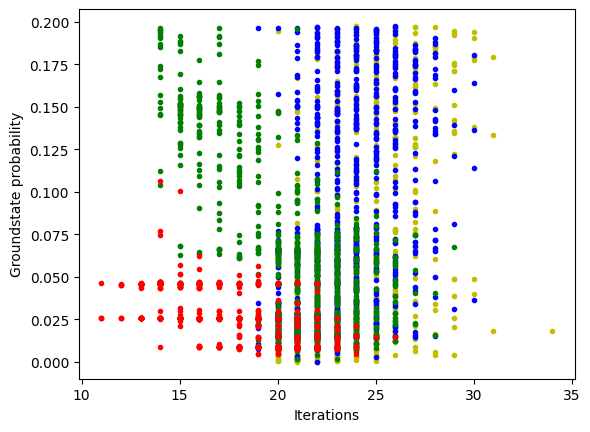

In [102]:
#Både denna och nästa cell ska tas bort så att dataanalysen istället görs i Data_analysis notebooken 

fig, ax = plt.subplots()
for prob_vector in data_library['data_for_alpha_1.0']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'y.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.25']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'b.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.1']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'g.', linewidth=0.01)
for prob_vector in data_library['data_for_alpha_0.05']["Ground state probability"]:    
    ax.plot(len(prob_vector), prob_vector[-1], 'r.', linewidth=0.01)
plt.xlabel('Iterations')
plt.ylabel('Groundstate probability')
plt.show()

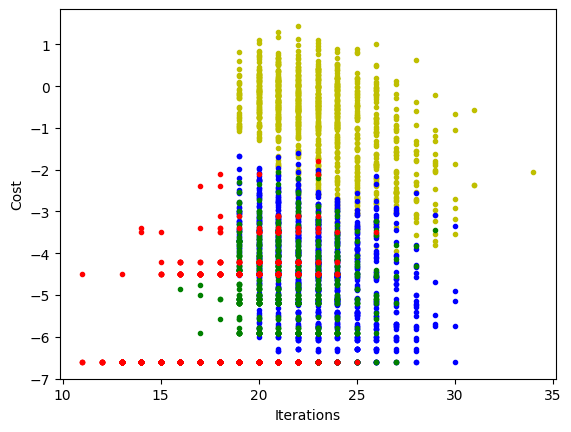

In [103]:
fig, ax = plt.subplots()
for cost_vector in data_library['data_for_alpha_1.0']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'y.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.25']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'b.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.1']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'g.', linewidth=1)
for cost_vector in data_library['data_for_alpha_0.05']["CVaR cost"]:    
    ax.plot(len(cost_vector), cost_vector[-1], 'r.', linewidth=1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()